In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import timedelta

from scipy.optimize import curve_fit
import scipy.integrate

from sklearn.metrics import mean_squared_error,mean_absolute_error

import numpy 
import matplotlib.pyplot as plt



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare dataset

Dataset are taken from [here](https://github.com/datasets/covid-19) which converted wide-formatted data provided by [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://github.com/CSSEGISandData/COVID-19) to long-formatted.

In [2]:

data_url= 'https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv'
req=requests.get(data_url)
case_report_by_country = pd.read_html(req.content)[0]
case_report_by_country = case_report_by_country[['Date','Country','Confirmed','Deaths']]
case_report_by_country['converted_date'] = pd.to_datetime(case_report_by_country['Date'])
case_report_by_country.head()


,Date,Country,Confirmed,Deaths,converted_date
0,2020-01-22,Afghanistan,0,0,2020-01-22
1,2020-01-22,Albania,0,0,2020-01-22
2,2020-01-22,Algeria,0,0,2020-01-22
3,2020-01-22,Andorra,0,0,2020-01-22
4,2020-01-22,Angola,0,0,2020-01-22


## First N days


In [3]:
case_report_by_counry_from_day1 = case_report_by_country[case_report_by_country['Confirmed']>0] #remove country with Confirmed=0
case_report_by_counry_from_day1["day"] = case_report_by_counry_from_day1.groupby(["Country"])["converted_date"].rank(ascending=True)
case_report_by_counry_from_day1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Country,Confirmed,Deaths,converted_date,day
36,2020-01-22,China,548,17,2020-01-22,1.0
86,2020-01-22,Japan,2,0,2020-01-22,1.0
90,2020-01-22,"Korea, South",1,0,2020-01-22,1.0
163,2020-01-22,Taiwan*,1,0,2020-01-22,1.0
165,2020-01-22,Thailand,2,0,2020-01-22,1.0


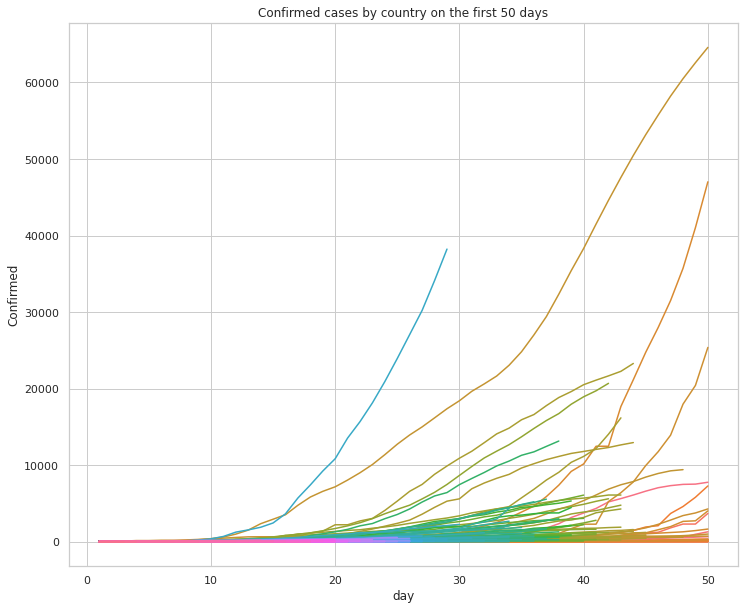

In [4]:
n = 50
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']!='China')]
plt.figure(figsize=(12, 10))
ax = sns.lineplot(x="day",y="Confirmed",hue="Country",data=first_n_day)
ax.set_title("Confirmed cases by country on the first "+ str(n)+" days")
ax.get_legend().set_visible(False)
plt.show()

## Cumulative cases

#### Thailand

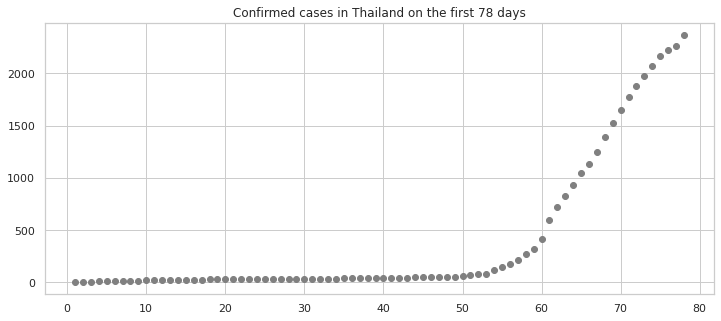

In [126]:
n = 100
country_list = ['Thailand']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['day'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

#### China

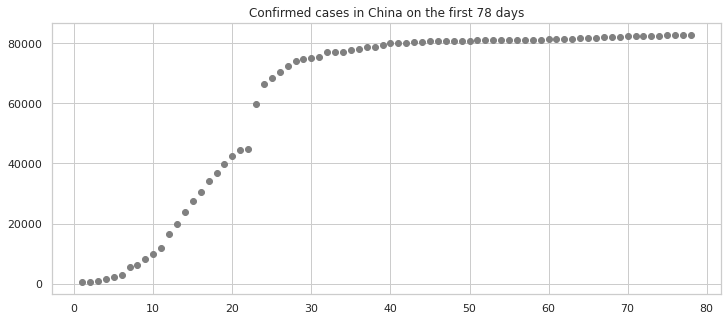

In [7]:
n = 100
country_list = ['China']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['day'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in China on the first "+ str(n)+" days")
plt.show()

#### South Korea

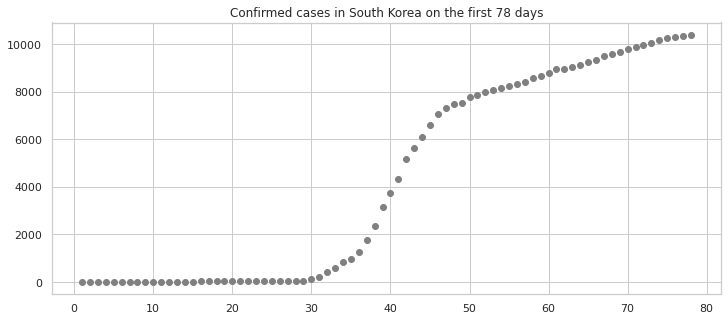

In [8]:
n = 100
country_list = ['Korea, South']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['day'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in South Korea on the first "+ str(n)+" days")
plt.show()

## New cases

In [9]:
new_case_report_by_country = case_report_by_counry_from_day1.copy()
new_case_report_by_country['yesterday'] = new_case_report_by_country['day']-1
new_case_report_by_country = new_case_report_by_country.merge(right = new_case_report_by_country,left_on = ['Country','yesterday'],right_on=['Country','day'])
new_case_report_by_country['new_confirmed'] = new_case_report_by_country['Confirmed_x'] - new_case_report_by_country['Confirmed_y']
new_case_report_by_country['new_deaths'] = new_case_report_by_country['Deaths_x'] - new_case_report_by_country['Deaths_y']
new_case_report_by_country = new_case_report_by_country[['Date_x','Country','new_confirmed','new_deaths','converted_date_x','day_x']].copy()
new_case_report_by_country.columns=['Date','Country','new_confirmed','new_deaths','converted_date','day']
new_case_report_by_country.head()

,Date,Country,new_confirmed,new_deaths,converted_date,day
0,2020-01-23,China,95,1,2020-01-23,2.0
1,2020-01-23,Japan,0,0,2020-01-23,2.0
2,2020-01-23,"Korea, South",0,0,2020-01-23,2.0
3,2020-01-23,Taiwan*,0,0,2020-01-23,2.0
4,2020-01-23,Thailand,1,0,2020-01-23,2.0


#### Thailand

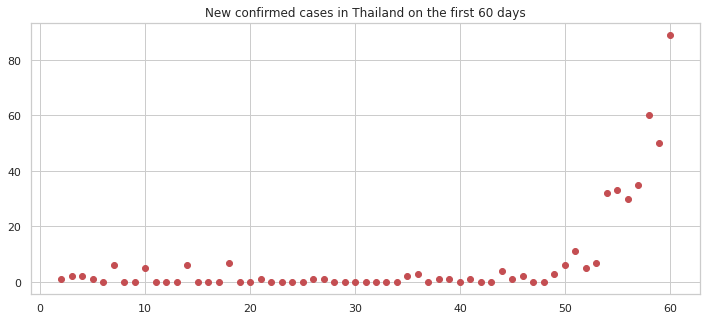

In [10]:
n = 60
country_list = ['Thailand']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

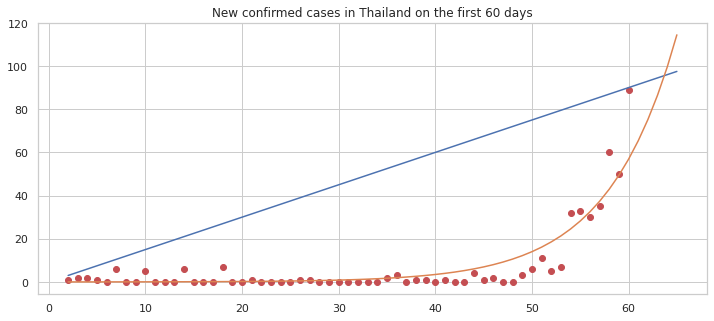

In [11]:
n = 60
x = np.arange(2,n+6)
y1 = 1.5*x
y2 = 0.006 * np.exp(0.14*(x+5.4))
country_list = ['Thailand']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.plot(x,y1)
plt.plot(x,y2)
plt.title("New confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

#### China

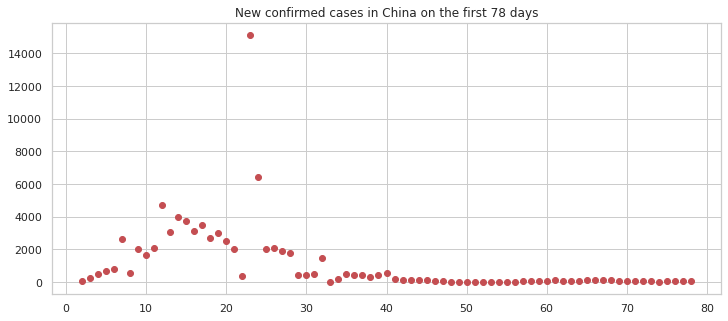

In [12]:
n = 120
country_list = ['China']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in China on the first "+ str(n)+" days")
plt.show()

#### Italy

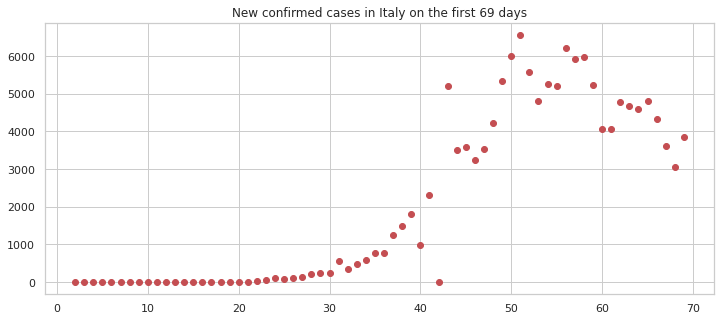

In [13]:
n = 120
country_list = ['Italy']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in Italy on the first "+ str(n)+" days")
plt.show()

#### South Korea

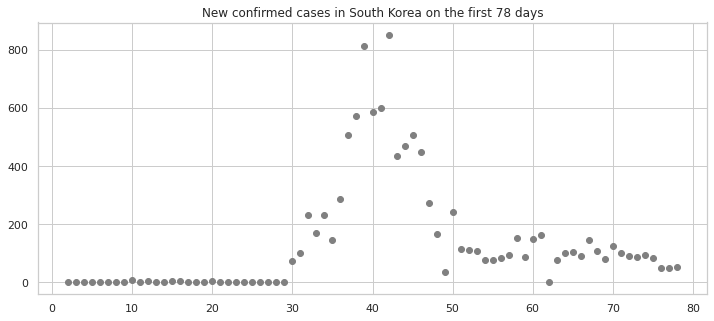

In [14]:
n = 120
country_list = ['Korea, South']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="grey")
plt.title("New confirmed cases in South Korea on the first "+ str(n)+" days")
plt.show()

# Exponential growth


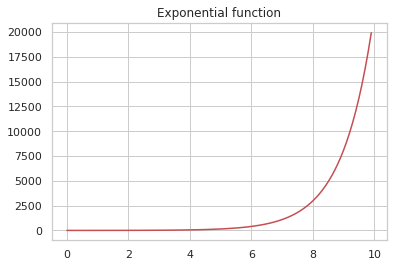

In [189]:
x = np.arange(0,10,0.1)
y = np.exp(x)
plt.plot(x,y,'r')
plt.title('Exponential function')
plt.show()

In [0]:
def exponential_model(x,a,b,c):
  return a*np.exp(b*(x-c))

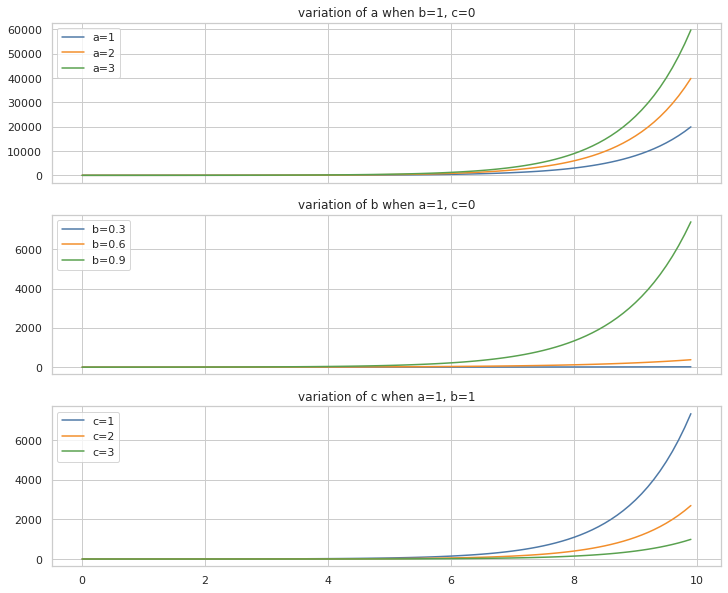

In [197]:
x = np.arange(0,10,0.1)
a_var = np.arange(1,4,1)
b_var = np.arange(0.3,1.1,0.3)
c_var = np.arange(1,4,1)

#a determines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True,figsize=(12,10))
for a in a_var:
  y = exponential_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = exponential_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = exponential_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

## Fit with least squared error


### Thailand


In [0]:
n_train = 60
n_predict = 70
country='Thailand'
country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
x= country_cases['day'].to_numpy()
y= country_cases['Confirmed'].to_numpy()
x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:n_predict]
y_test = y[n_train:n_predict]

In [22]:
  exp_fit = curve_fit(exponential_model,x_train,y_train,p0=[0.1,-0.1,0.1])
  a_pred = exp_fit[0][0]
  b_pred = exp_fit[0][1]
  c_pred = exp_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

a_pred = 0.07584587236524387
b_pred = 0.16829746712913493
c_pred = 9.428545351739222


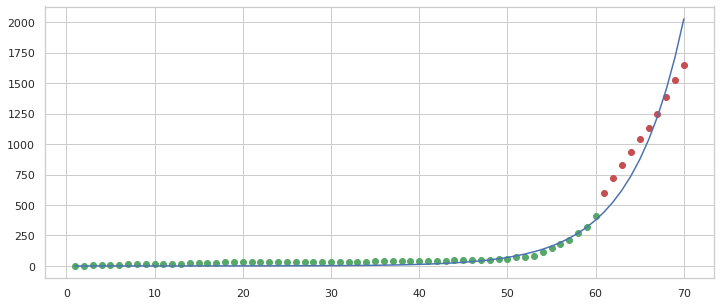

In [23]:
  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred, label="Exponential model of " + country )
  plt.show()

In [24]:
mean_absolute_error(y_train, y_pred[:n_train])

21.938669157761545

In [25]:
mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])

166.48131019291998

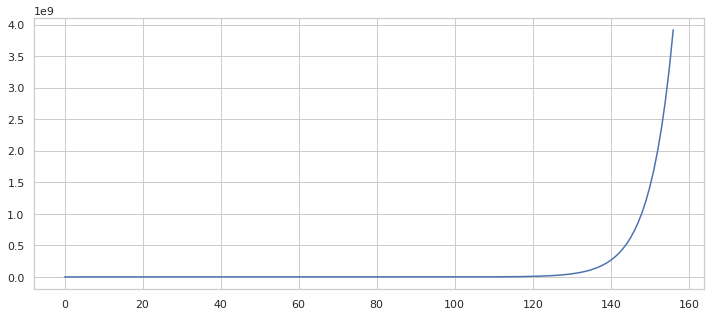

In [26]:
x = np.arange(0,157)
y_pred = exponential_model(x,a=a_pred,b=b_pred,c=c_pred)
plt.figure(figsize=(12, 5))
plt.plot(x, y_pred, label="Exponential model" )
plt.show()

reach 35 million people in 123 days (around 4 months)

### Write a function for reusability

In [0]:
def exponential_model_least_square_plot(country,n_train,n_predict,initial_param=[1,1,-1]):
  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_train = x[:n_train]
  y_train = y[:n_train]

  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  
  exp_fit = curve_fit(exponential_model,x_train,y_train,p0=initial_param)
  a_pred = exp_fit[0][0]
  b_pred = exp_fit[0][1]
  c_pred = exp_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred)
  plt.title("Exponential model of " + country )
  plt.show()

a_pred = 0.013405323031150785
b_pred = 0.16830423451189766
c_pred = -0.86661933535734
MAE (training set) = 21.93849313462637
MAE (test set) = 166.49578072684648


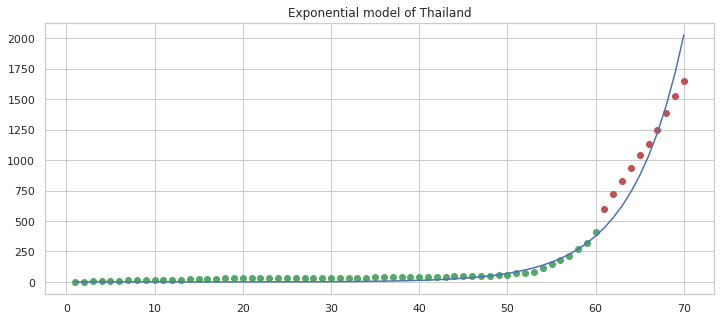

In [28]:
exponential_model_least_square_plot(country='Thailand',n_train=60,n_predict = 70)

#### Italy

a_pred = 3.6092717996339747
b_pred = 0.1550507430917281
c_pred = -11.347753801767654
MAE (training set) = 615.3986855349573
MAE (test set) = 222847.07319058856


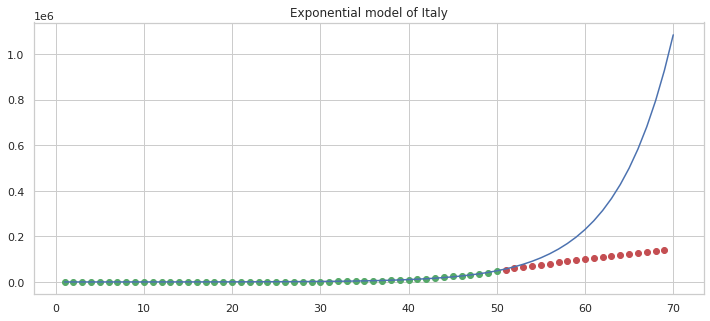

In [29]:
exponential_model_least_square_plot(country='Italy',n_train=50,n_predict = 70)

#### South Korea

a_pred = 0.06302045623278638
b_pred = 0.27560434575485104
c_pred = -0.04469694435291592
MAE (training set) = 39.28218090453136
MAE (test set) = 17450.61400530933


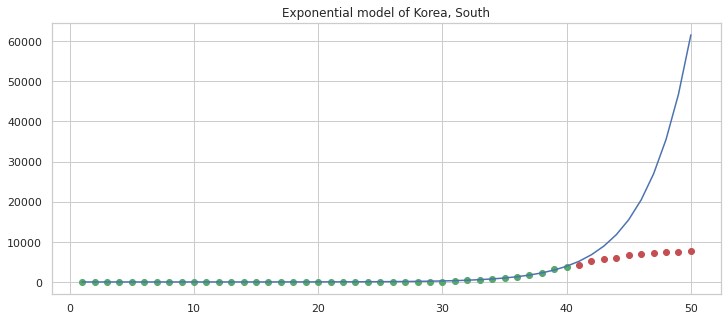

In [30]:
exponential_model_least_square_plot(country='Korea, South',n_train=40,n_predict = 50)

#### Japan

a_pred = 4.8895784201472186
b_pred = 0.09398420718263376
c_pred = -1.9735131360016167
MAE (training set) = 9.332891862161755
MAE (test set) = 830.2399826251564


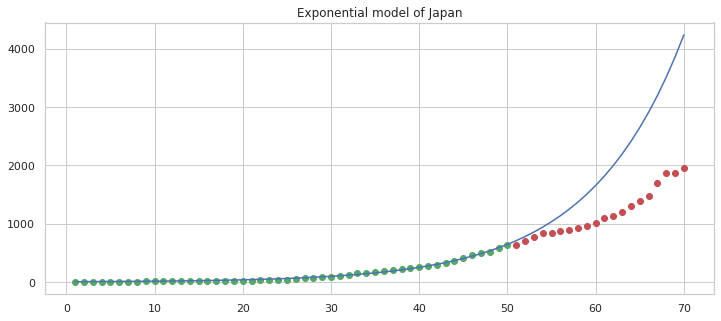

In [31]:
exponential_model_least_square_plot(country='Japan',n_train=50,n_predict = 70)

#### China

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


a_pred = 241.77016121817277
b_pred = 0.049216650327906473
c_pred = -82.66178568441978
MAE (training set) = 10986.014949065931
MAE (test set) = 95760.99980531454


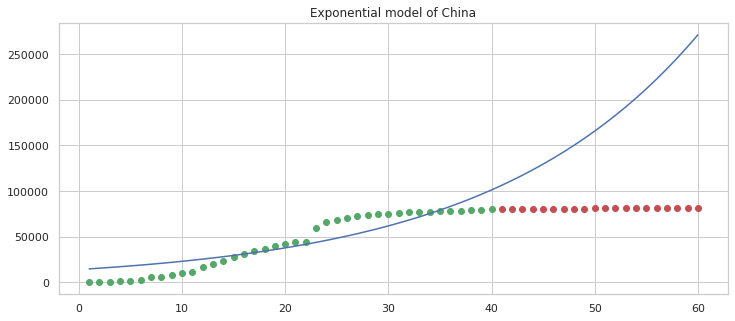

In [32]:
exponential_model_least_square_plot(country='China',n_train=40,n_predict = 60,initial_param=(4,0,-1))

## Fit with maximum likelihood estimation 
source code modified 
from [stackexchange](https://stats.stackexchange.com/questions/66199/maximum-likelihood-curve-model-fitting-in-python) 

### Write a function

In [0]:
def exponential_model_mle_plot_frequency(country,n_train,n_predict,initial_param=[1,1,-1],distribution='gaussian',show_test_set = True):

  country_list = ['Thailand']
  new_case_by_selected_country = new_case_report_by_country[new_case_report_by_country['Country']==country]
  x = new_case_by_selected_country['day'].to_numpy()
  y= new_case_by_selected_country['new_confirmed'].to_numpy()
  x_train = x[:n_train-1]
  y_train = y[:n_train-1]

  x_test = x[n_train-1:n_predict-1]
  y_test = y[n_train-1:n_predict-1]

  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_accum = x[:n_predict]

  x_accum_train = x[:n_train]
  y_accum_train = y[:n_train]
  x_accum_test = x[n_train:n_predict]
  y_accum_test = y[n_train:n_predict]

  def sum_negative_log_likelihood_gaussian(params):
    a,b,c,sd = params
    y = exponential_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum( stats.norm.logpdf(y_train, loc=y, scale=sd ) )
    return (neg_log_likelihood)

  def sum_negative_log_likelihood_poisson(params):
    a,b,c = params
    y = exponential_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum(stats.poisson.logpmf(y_train, mu=y))
    return (neg_log_likelihood)
  if distribution == 'gaussian':
    exp_fit = minimize(sum_negative_log_likelihood_gaussian, initial_param, method='Nelder-Mead')
  else:
    exp_fit = minimize(sum_negative_log_likelihood_poisson, initial_param, method='Nelder-Mead')
    
  a_pred = exp_fit.x[0]
  b_pred = exp_fit.x[1]
  c_pred = exp_fit.x[2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)
  y_pred_accum = np.cumsum(y_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train-1)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train-1:n_train-1+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="Actual new confirmed cases (Train)",color="g")
  if show_test_set:
    plt.scatter(x_test,y_test,label="Actual new confirmed cases (Test)",color="r")
  plt.plot(x_pred, y_pred,label="Predicted new confirmed cases")
  plt.title("Daily new confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

  plt.figure(figsize=(12, 5))
  plt.scatter(x_accum_train,y_accum_train,label="Actual cumulative confirmed cases",color="grey")

  if show_test_set:
    plt.scatter(x_accum_test,y_accum_test,color="grey")
  plt.plot(x_pred, y_pred_accum, label ="Predicted cumulative confirmed cases" )
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

#### Thailand

a_pred = 0.007414091312816353
b_pred = 0.12727963805123516
c_pred = -10.415635771794566
MAE (training set) = 8.090203184973795
MAE (test set) = 148.53850458010126


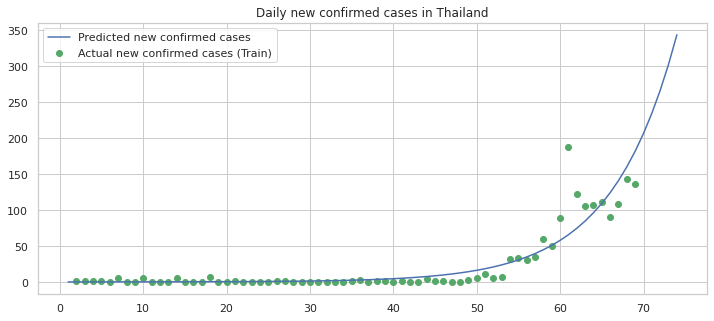

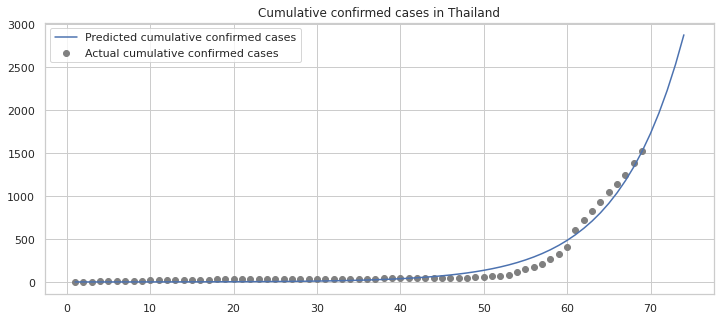

a_pred = 0.007414091312816353
b_pred = 0.12727963805123516
c_pred = -10.415635771794566
MAE (training set) = 8.090203184973795
MAE (test set) = 148.53850458010126


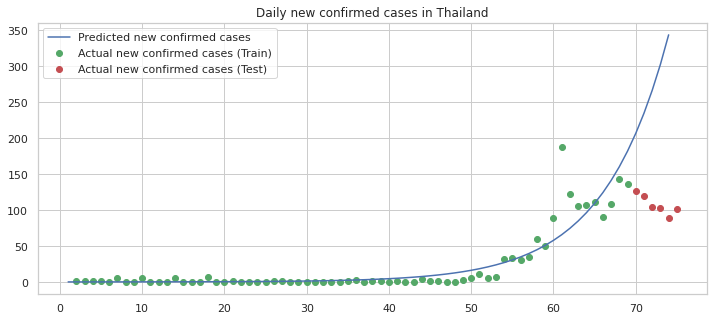

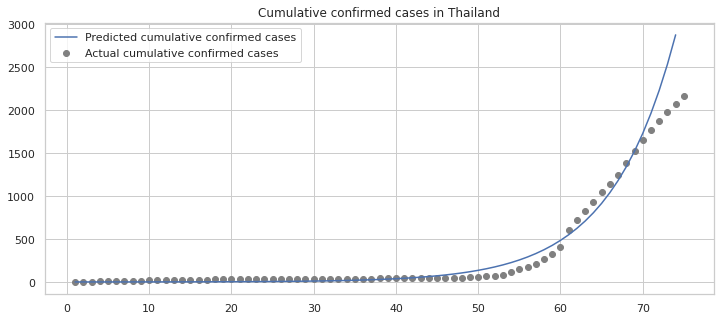

In [154]:
# exponential_model_mle_plot_frequency(country='Thailand',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [1,0.01,1,11])
exponential_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 75,distribution = 'poisson',initial_param = [1,0.01,1],show_test_set=False)
exponential_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 75,distribution = 'poisson',initial_param = [1,0.01,1])

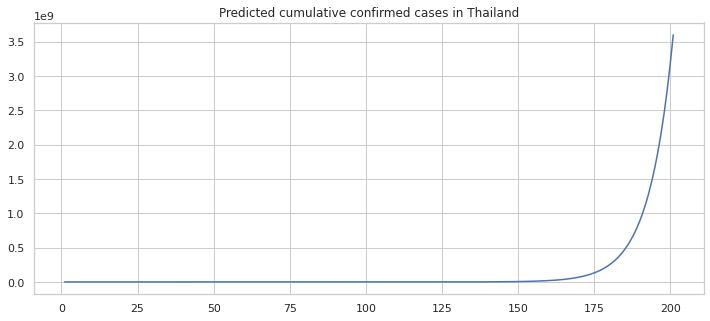

In [162]:
x= np.arange(1,202)
y = exponential_model(x,a = 0.007414091312816353,b=0.12727963805123516,c= -10.415635771794566)
plt.figure(figsize=(12, 5))
plt.plot(x, y)
plt.title("Predicted cumulative confirmed cases in " + country )
plt.show()

#### Italy

a_pred = 56.42345199390697
b_pred = 0.09452404364623619
c_pred = 6.095598562744933
MAE (training set) = 649.9603896529427
MAE (test set) = 9660.305316798685


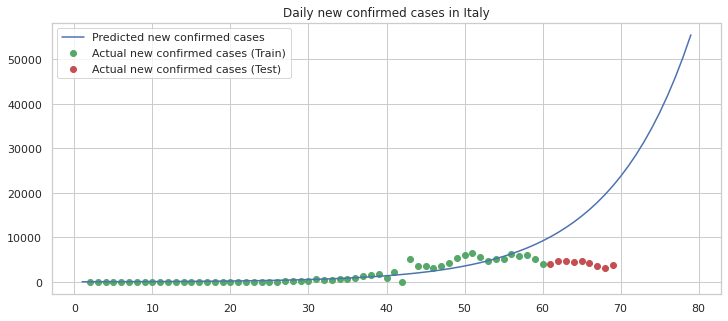

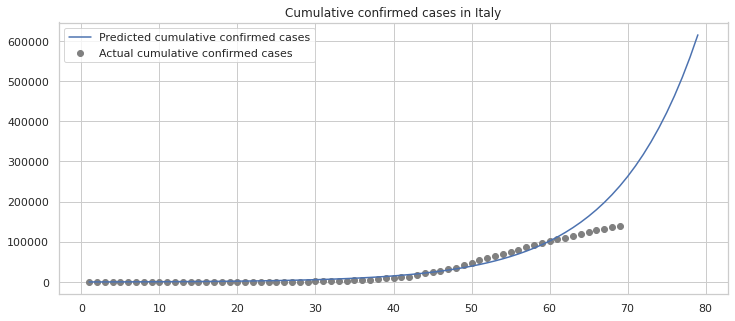

In [37]:
# exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [10,0.1,8,3])
exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### South Korea

a_pred = 15.605430526220566
b_pred = 0.043317340465382534
c_pred = -15.136079553271424
MAE (training set) = 146.5450602479872
MAE (test set) = 511.1696503042925


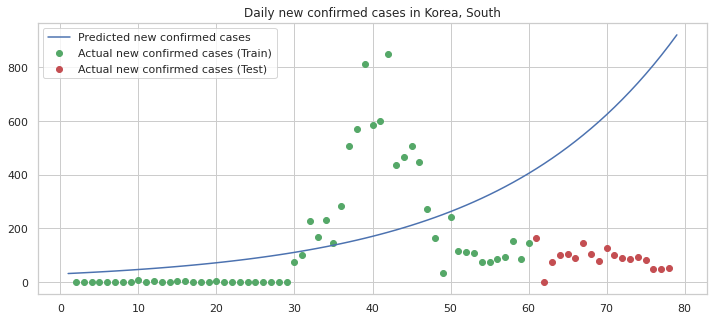

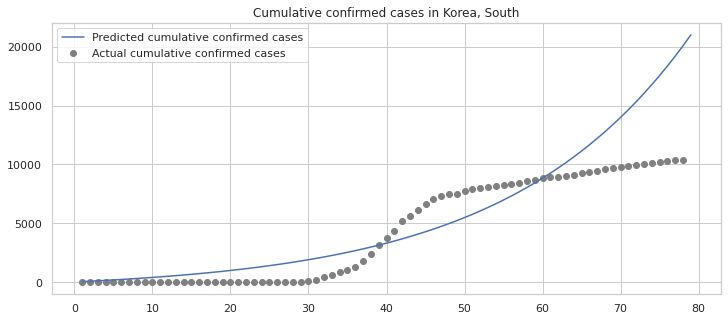

In [38]:
# exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [10,0.1,8,3])
exponential_model_mle_plot_frequency(country='Korea, South',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### Japan

a_pred = 1.6608303017440909
b_pred = 0.06079656824769594
c_pred = 0.7362958518088469
MAE (training set) = 9.49627664789226
MAE (test set) = 107.40488823367959


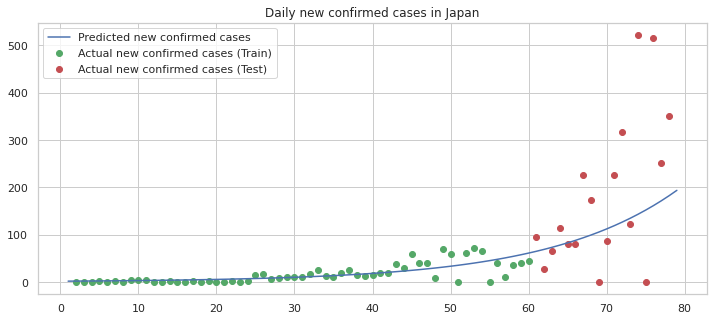

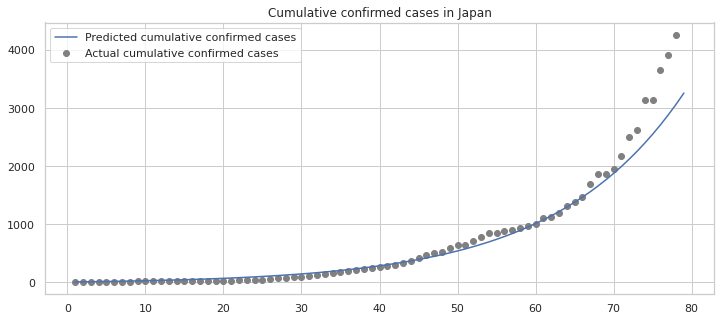

In [39]:
exponential_model_mle_plot_frequency(country='Japan',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### China

a_pred = 84.01610491645849
b_pred = 0.0316061346269621
c_pred = -91.12850320973425
MAE (training set) = 1674.2073688420992
MAE (test set) = 8760.590985060197


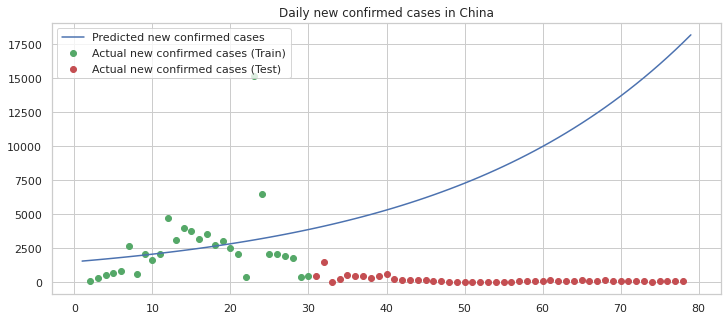

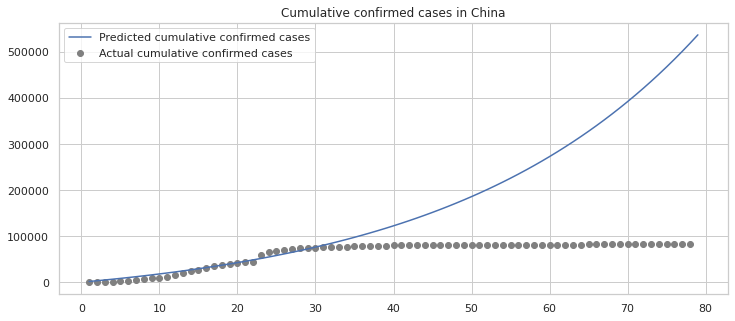

In [40]:
exponential_model_mle_plot_frequency(country='China',n_train=30,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

# Logistic growth

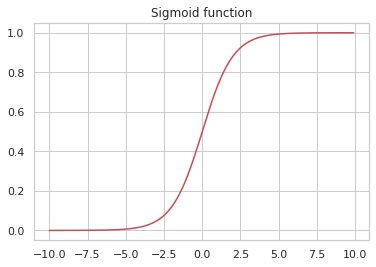

In [41]:
x = np.arange(-10,10,0.1)
y = 1/(1+np.exp(-x))
plt.plot(x,y,'r')
plt.title('Sigmoid function')
plt.show()

In [0]:
def logistic_model(x,a,b,c):
  return a/(1+np.exp(-b*(x-c)))

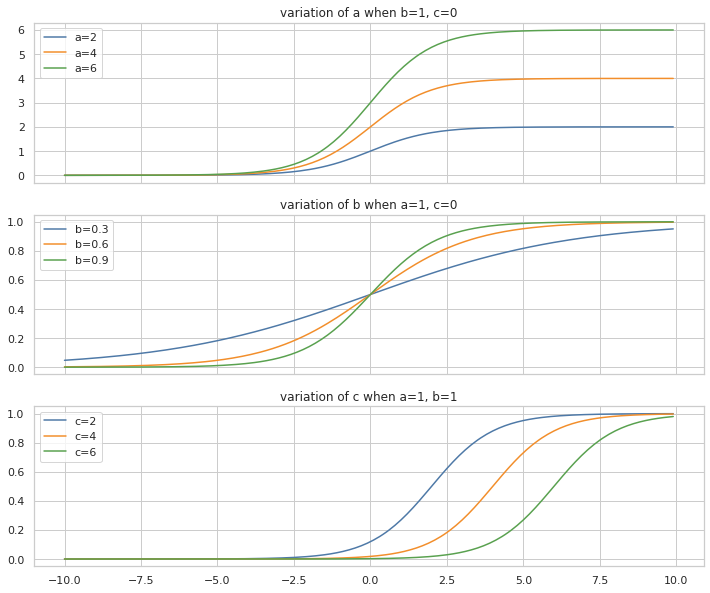

In [198]:
x = np.arange(-10,10,0.1)
a_var = np.arange(2,7,2)
b_var = np.arange(0.3,1,0.3)
c_var = np.arange(2,7,2)

#a defines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True,figsize=(12,10))
for a in a_var:
  y = logistic_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = logistic_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

## Fit with least squared error

### Thailand

In [0]:
n = 100
country= 'Thailand'
thailand_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']==country)]
x_train = thailand_cases['day'].to_numpy()
y_train = thailand_cases['Confirmed'].to_numpy()

In [0]:
logistic_fit = curve_fit(logistic_model,x_train,y_train,p0=[1500,0.5,20])
a_pred = logistic_fit[0][0]
b_pred = logistic_fit[0][1]
c_pred = logistic_fit[0][2]
y_pred = logistic_model(x_train,a=a_pred,b=b_pred,c=c_pred)

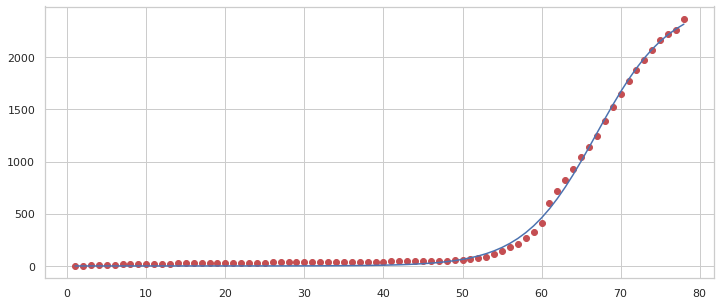

In [49]:
plt.figure(figsize=(12, 5))
plt.scatter(x_train,y_train,label="actual confirmed",color="r")
plt.plot(x_train, y_pred, label="Logistic model" )
plt.show()

In [50]:
logistic_fit

(array([2.52943714e+03, 2.16502236e-01, 6.69372867e+01]),
 array([[ 1.24826878e+03, -1.48420066e-01,  6.09938035e+00],
        [-1.48420066e-01,  2.63333230e-05, -7.34512484e-04],
        [ 6.09938035e+00, -7.34512484e-04,  3.43652014e-02]]))

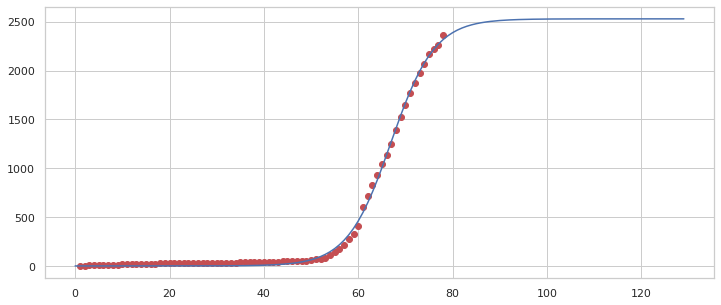

In [51]:
plt.figure(figsize=(12, 5))
x_test = np.arange(0,130)

y_pred = logistic_model(x_test,a_pred,b_pred,c_pred)
plt.scatter(x_train,y_train,label="actual confirmed",color="r")
plt.plot(x_test, y_pred, label="Logistic model" )

## Write a function for reusability

In [0]:
def logistic_model_plot(country,n_train,n_predict):
  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_train = x[:n_train]
  y_train = y[:n_train]

  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  initial_param = [np.max(y_train),0.1,50] # init parameter with 1.5 times of current confirmed cases
  logistic_fit = curve_fit(logistic_model,x_train,y_train,p0=initial_param) #, maxfev=5000)
  a_pred = logistic_fit[0][0]
  b_pred = logistic_fit[0][1]
  c_pred = logistic_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = logistic_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred)
  plt.title("Logistic model of " + country )
  plt.show()


#### Thailand

a_pred = 2181.4524990029863
b_pred = 0.2598356371507738
c_pred = 65.11564589026649
MAE (training set) = 26.139496245559897
MAE (test set) = 99.97901347838511


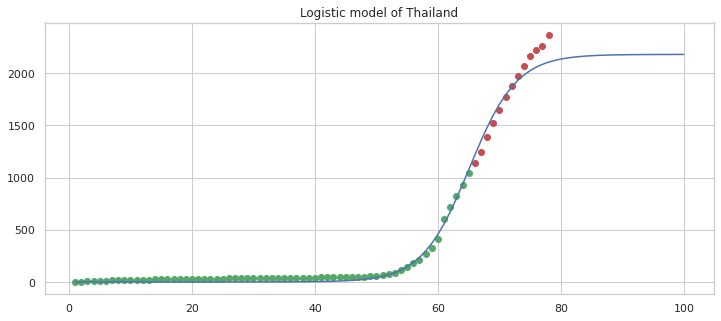

In [53]:
logistic_model_plot(country='Thailand',n_train=65,n_predict = 100)

#### China

a_pred = 80830.19531424815
b_pred = 0.22263144157276432
c_pred = 18.74160162630976
MAE (training set) = 1584.4409594135725
MAE (test set) = 838.3048945998462


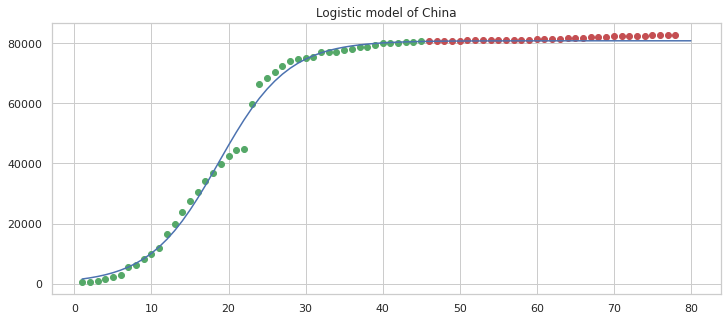

In [54]:
logistic_model_plot(country='China',n_train=45,n_predict = 80)

#### Italy

a_pred = 96457.36449568656
b_pred = 0.20633938393558574
c_pred = 50.38599970687205
MAE (training set) = 250.19294644757858
MAE (test set) = 19393.19309379428


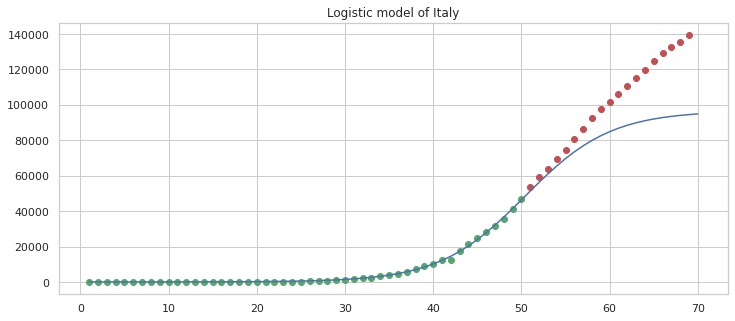

In [55]:
logistic_model_plot(country='Italy',n_train=50,n_predict = 70)

#### South Korea

a_pred = 8505.091991951196
b_pred = 0.36129894015612374
c_pred = 40.622683066253934
MAE (training set) = 30.424217988350808
MAE (test set) = 731.4053109647102


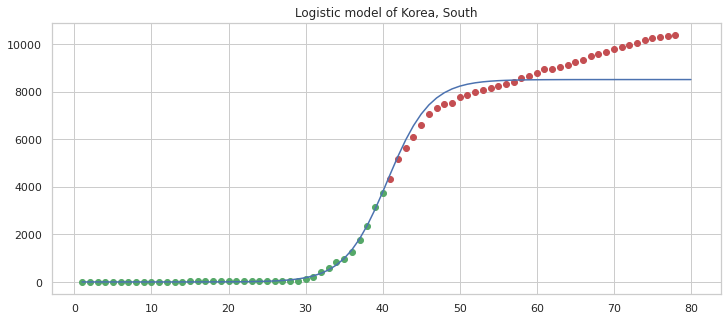

In [56]:
logistic_model_plot(country='Korea, South',n_train=40,n_predict = 80)

#### Japan

a_pred = 1369.6884678162587
b_pred = 0.12302258066416515
c_pred = 51.573488017763864
MAE (training set) = 9.94595269824366
MAE (test set) = 1027.6346462322608


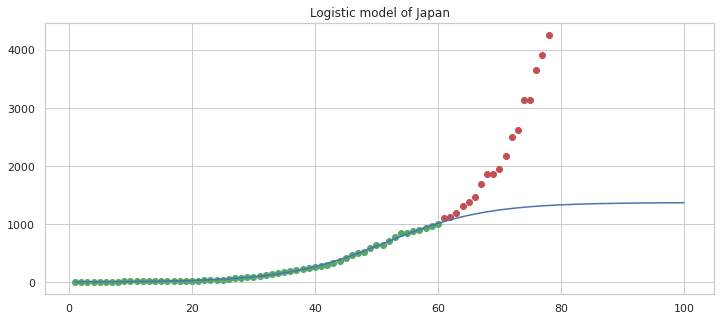

In [57]:
logistic_model_plot(country='Japan',n_train=60,n_predict = 100)

#### USA

a_pred = 179824.66170377107
b_pred = 0.3346402827462603
c_pred = 65.49066148341902
MAE (training set) = 214.73103277205195
MAE (test set) = 100841.66094227218


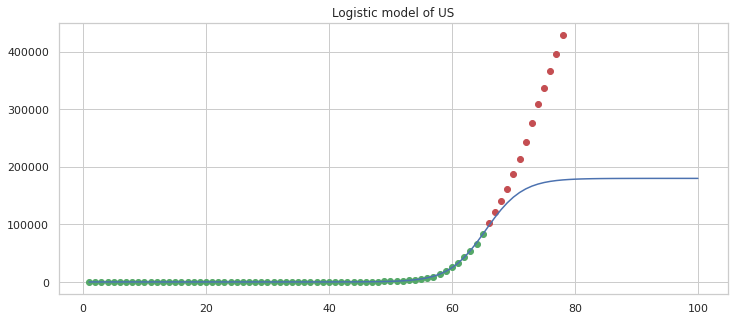

In [58]:
logistic_model_plot(country='US',n_train=65,n_predict = 100)

## Fit with maximum likelihood estimation 

In [0]:
def logistic_dist_model(x,a,b,c):
  return a*np.exp(-b*(x-c))/(1+np.exp(-b*(x-c)))**2

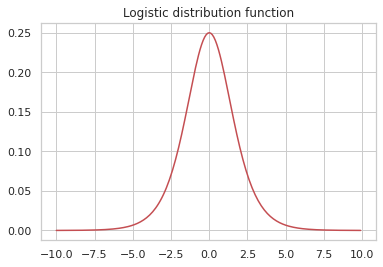

In [60]:
x = np.arange(-10,10,0.1)
y = np.exp(-x)/((1+np.exp(-x))*(1+np.exp(-x)))
plt.plot(x,y,'r')
plt.title('Logistic distribution function')
plt.show()

In [0]:
x = np.arange(-10,10,0.1)
a_var = np.arange(1,4,1)
b_var = np.arange(0.2,1.1,0.4)
c_var = np.arange(2,7,2)

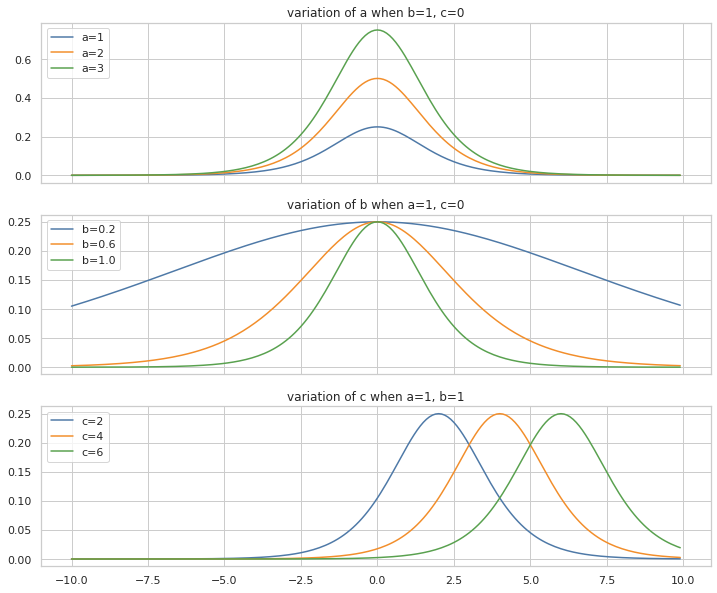

In [187]:
#a determines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True,figsize=(12,10))
for a in a_var:
  y = logistic_dist_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = logistic_dist_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(b)[:3])
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_dist_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

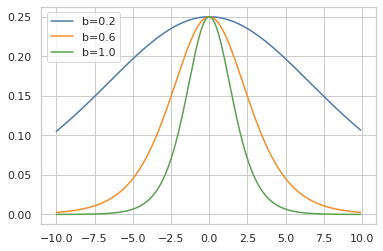

In [169]:
#b determines growth rate
i=0
for b in b_var:
  y = logistic_dist_model(x,a=1,b=b,c=0)
  plt.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
plt.legend(loc="upper left")
plt.show()

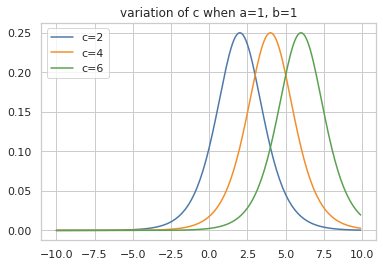

In [172]:
#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_dist_model(x,a=1,b=1,c=c)
  plt.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
plt.title('variation of c when a=1, b=1')
plt.legend(loc="upper left")
plt.show()

### Write a function

In [0]:
def logistic_model_mle_plot_frequency(country,n_train,n_predict,initial_param=[1,1,-1],distribution='gaussian',show_test_set = True):

  country_list = ['Thailand']
  new_case_by_selected_country = new_case_report_by_country[new_case_report_by_country['Country']==country]
  x = new_case_by_selected_country['day'].to_numpy()
  y= new_case_by_selected_country['new_confirmed'].to_numpy()
  x_train = x[:n_train-1]
  y_train = y[:n_train-1]

  x_test = x[n_train-1:n_predict-1]
  y_test = y[n_train-1:n_predict-1]

  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_accum = x[:n_predict]

  x_accum_train = x[:n_train]
  y_accum_train = y[:n_train]
  x_accum_test = x[n_train:n_predict]
  y_accum_test = y[n_train:n_predict]

  def sum_negative_log_likelihood_gaussian(params):
    a,b,c,sd = params
    y = logistic_dist_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum( stats.norm.logpdf(y_train, loc=y, scale=sd ) )
    return (neg_log_likelihood)

  def sum_negative_log_likelihood_poisson(params):
    a,b,c = params
    y = logistic_dist_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum(stats.poisson.logpmf(y_train, mu=y))
    return (neg_log_likelihood)
  if distribution == 'gaussian':
    exp_fit = minimize(sum_negative_log_likelihood_gaussian, initial_param, method='Nelder-Mead')
  else:
    exp_fit = minimize(sum_negative_log_likelihood_poisson, initial_param, method='Nelder-Mead')
    
  a_pred = exp_fit.x[0]
  b_pred = exp_fit.x[1]
  c_pred = exp_fit.x[2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict)
  y_pred = logistic_dist_model(x_pred,a=a_pred,b=b_pred,c=c_pred)
  y_pred_accum = np.cumsum(y_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train-1)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train-1:n_train-1+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="Actual new confirmed cases (Train)",color="g")
  if show_test_set:
    plt.scatter(x_test,y_test,label="Actual new confirmed cases (Test)",color="r")
  plt.plot(x_pred, y_pred,label="Predicted new confirmed cases")
  plt.title("Daily new confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

  plt.figure(figsize=(12, 5))
  plt.scatter(x_accum_train,y_accum_train,label="Actual cumulative confirmed cases",color="grey")

  if show_test_set:
    plt.scatter(x_accum_test,y_accum_test,color="grey")
  plt.plot(x_pred, y_pred_accum, label ="Predicted cumulative confirmed cases" )
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

a_pred = 654.3341354622005
b_pred = 0.1623862018488214
c_pred = 72.5726017078317
MAE (training set) = 6.8684686577946135
MAE (test set) = 62.69411757023546


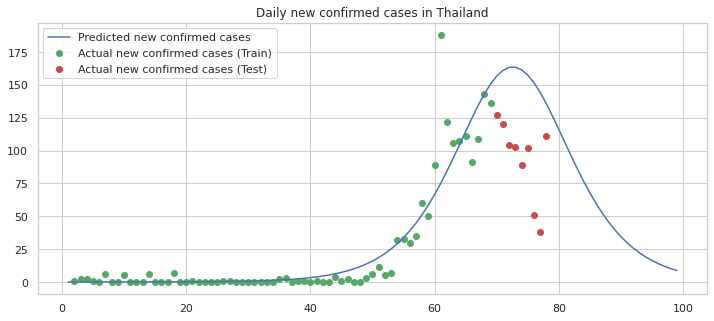

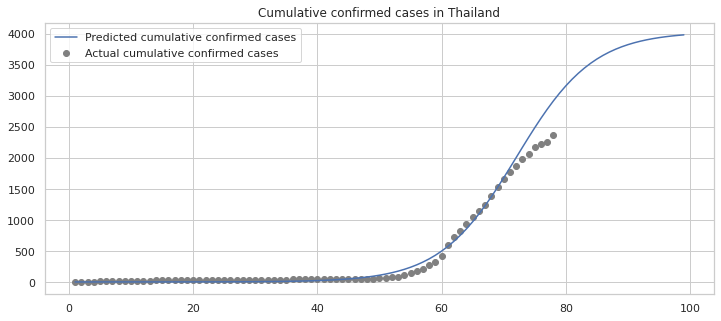

In [200]:
# logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 100,initial_param = [150, 0.01,70,30],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 100,initial_param = [150, 0.01,70],distribution='poisson')

a_pred = 23678.38355863856
b_pred = -0.17414016481151845
c_pred = 53.98677807364418
MAE (training set) = 299.7724377362887
MAE (test set) = 1324.9515698635564


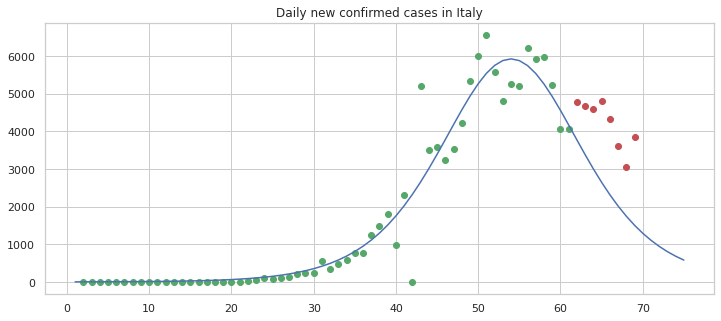

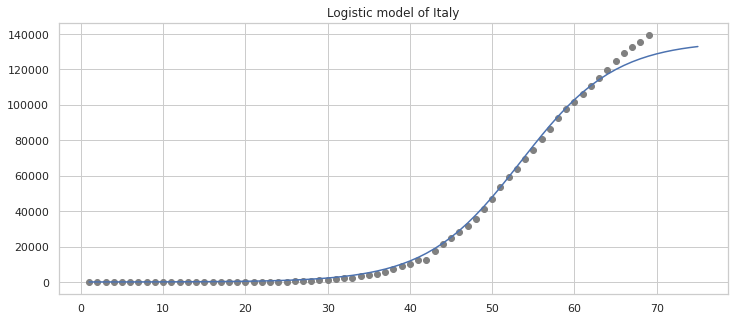

a_pred = 24387.73459420886
b_pred = 0.18752903050179
c_pred = 53.6496343530716
MAE (training set) = 303.9807209351195
MAE (test set) = 1626.4659845310875


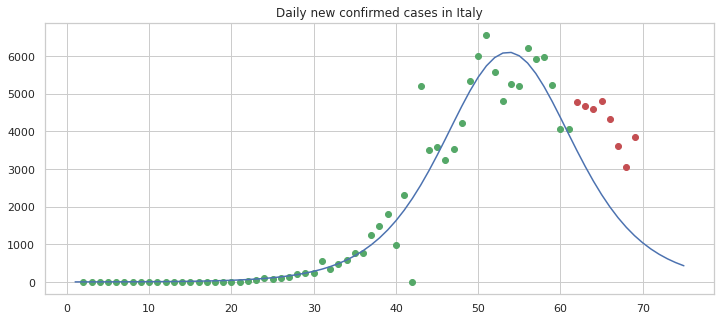

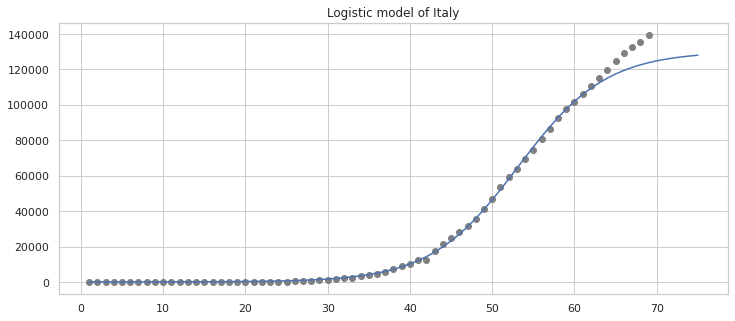

In [71]:
logistic_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 75,initial_param = [7000, 0.1,50,3],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 75,initial_param = [7000, 0.1,50],distribution='poisson')

a_pred = -9563103.817638459
b_pred = -115.01302625253854
c_pred = 9464.817247966426
MAE (training set) = 1348.1166666666666
MAE (test set) = 82.0


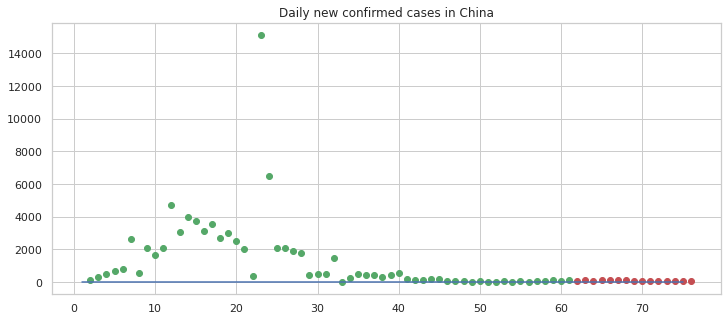

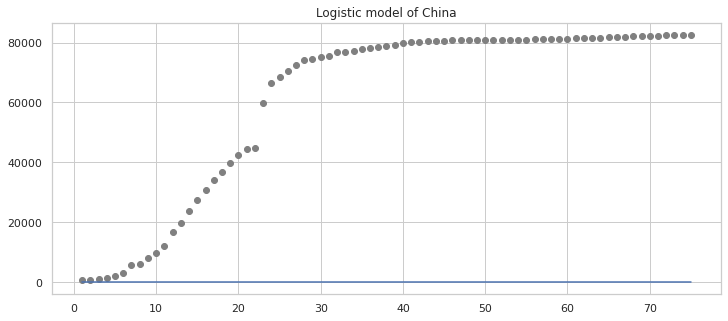

a_pred = 17220.829425477852
b_pred = 0.20747150022820265
c_pred = 19.081823576723828
MAE (training set) = 735.5905818466443
MAE (test set) = 81.02177947236109


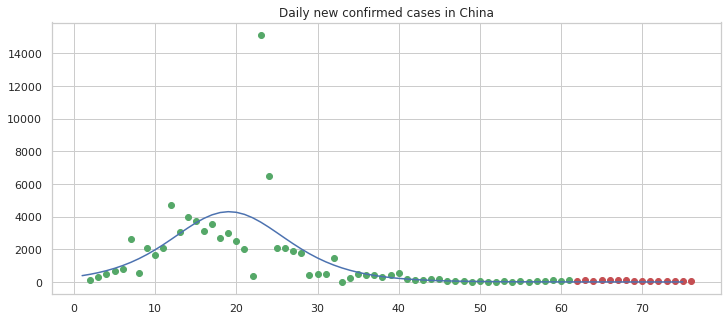

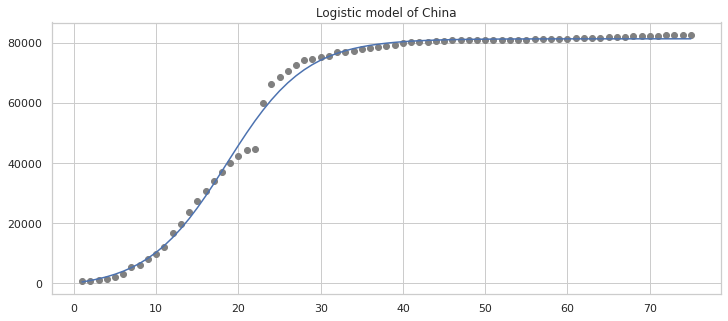

In [72]:
logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 75,initial_param = [18000, 0.2,15,3],distribution='gaussian')
logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 75,initial_param = [20000, 0.1,20],distribution='poisson')

#### Thailand

a_pred = 529.037710811589
b_pred = 0.41619658509951407
c_pred = 62.48917060811908
MAE (training set) = 4.726131058660229
MAE (test set) = 79.49373393702182


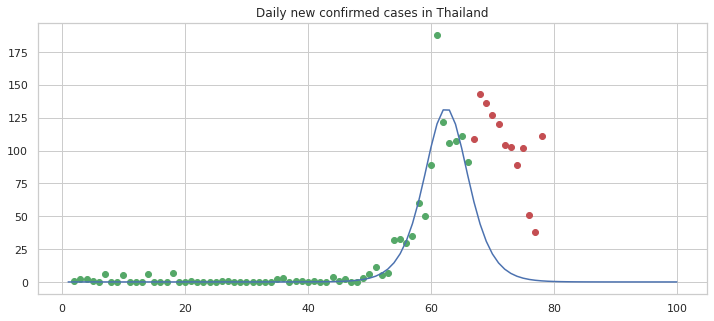

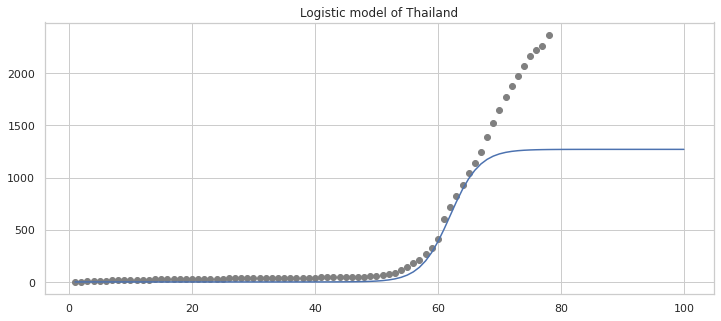

a_pred = 21205.07133179252
b_pred = 0.1424086186888574
c_pred = 100.6888395033931
MAE (training set) = 6.982982222095314
MAE (test set) = 255.2682278626504


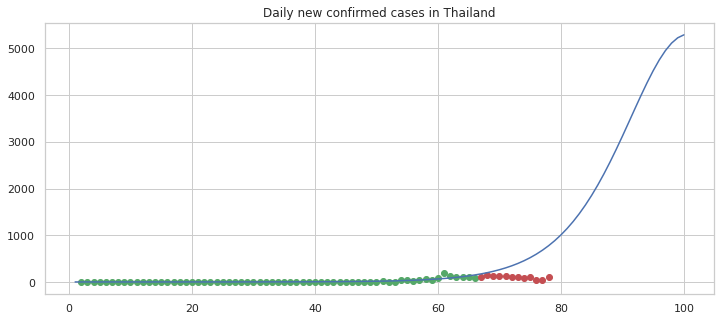

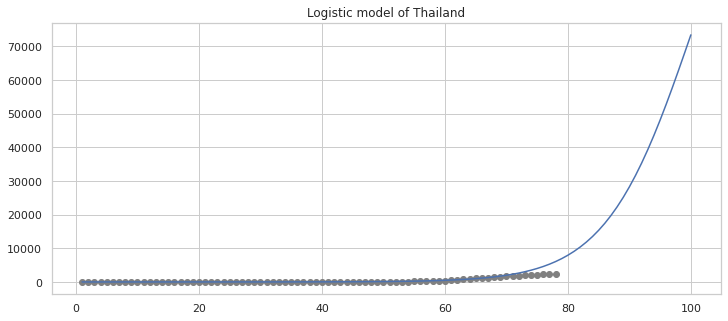

In [73]:
logistic_model_mle_plot_frequency(country='Thailand',n_train=65,n_predict = 100,initial_param = [2000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Thailand',n_train=65,n_predict = 100,initial_param = [2181, 0.25,65],distribution='poisson')

a_pred = 132045.0035282117
b_pred = 0.1654227912931178
c_pred = 105.02248273961689
MAE (training set) = 4.971613903230002
MAE (test set) = 358.96730071810975


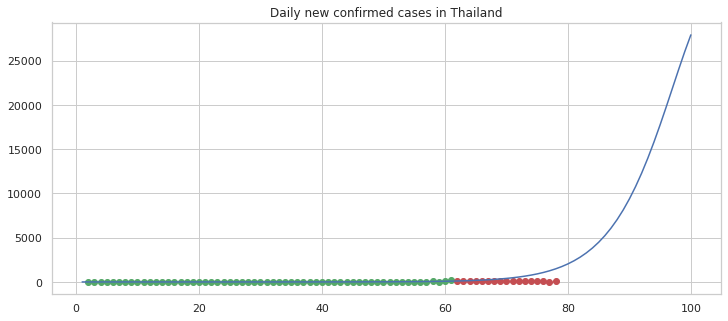

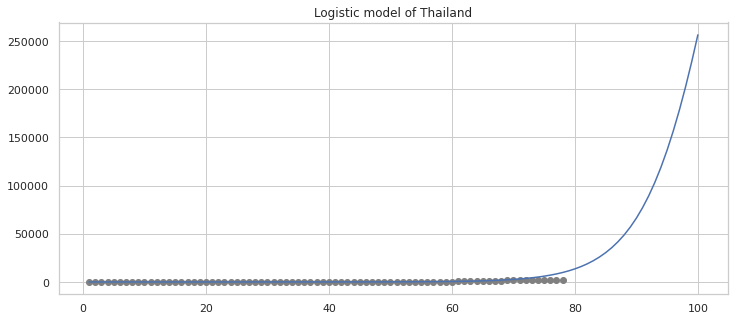

In [74]:
logistic_model_mle_plot_frequency(country='Thailand',n_train=60,n_predict = 100,initial_param = [2000, 0.1,50],distribution='poisson')

#### Italy

a_pred = 37370.43436022221
b_pred = 0.1582978178575596
c_pred = 59.04694735859172
MAE (training set) = 255.44171342131472
MAE (test set) = 3255.5273170596183


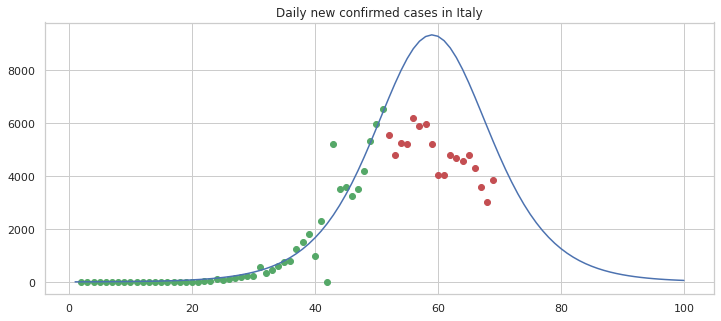

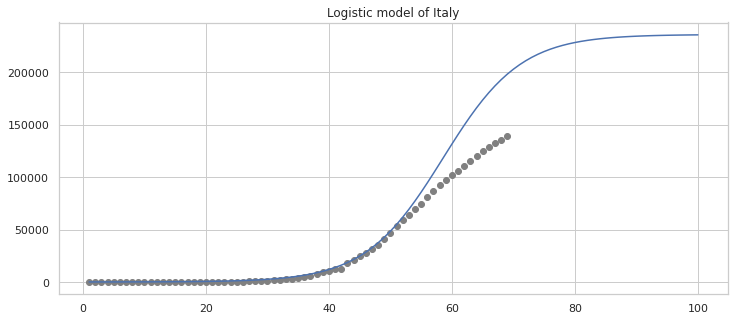

a_pred = 24432.550577559672
b_pred = 0.19861842004152974
c_pred = 52.80374129685035
MAE (training set) = 263.0330847918218
MAE (test set) = 1264.6860027233654


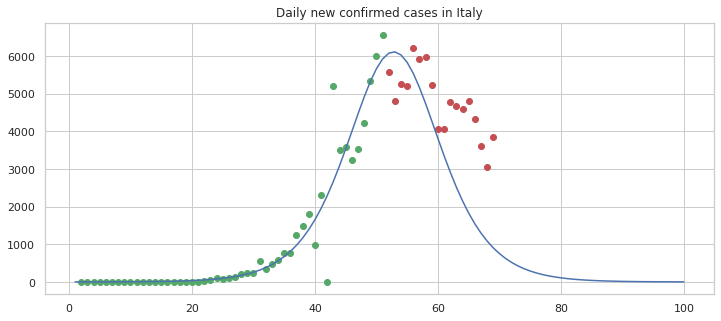

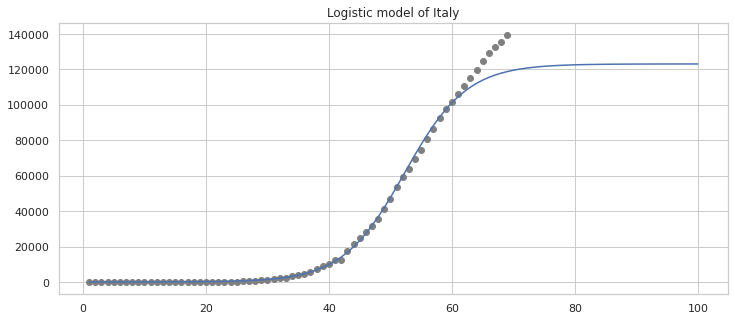

In [75]:
logistic_model_mle_plot_frequency(country='Italy',n_train=50,n_predict = 100,initial_param = [120000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Italy',n_train=50,n_predict = 100,initial_param = [120000, 0.2,100],distribution='poisson')

#### China

a_pred = 16279.38282440021
b_pred = -0.19290790001054858
c_pred = 19.099888970275046
MAE (training set) = 662.1598257874937
MAE (test set) = 67.32851674098946


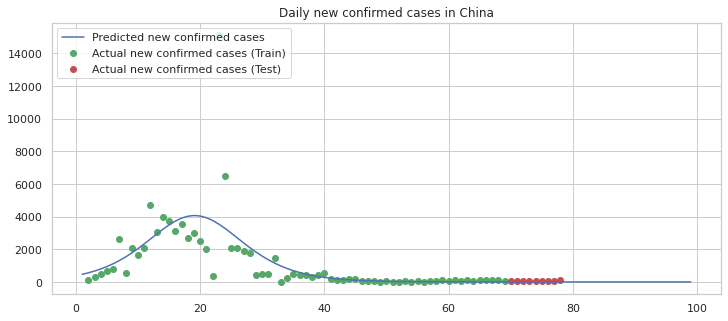

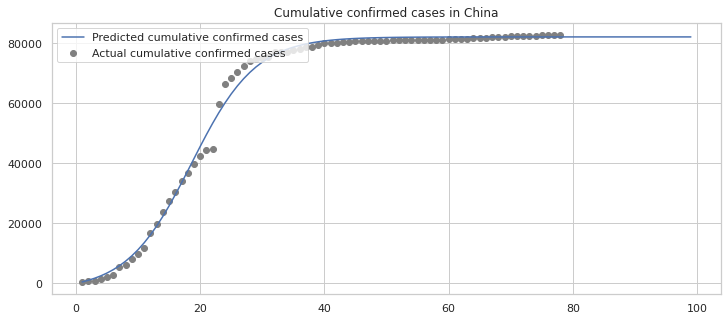

In [211]:
# logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 100,initial_param = [120000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='China',n_train=69,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 7274.028677069627
b_pred = -0.5765345259410731
c_pred = 8.610592872592052
MAE (training set) = 392.67388991478174
MAE (test set) = 1004.2928264176667


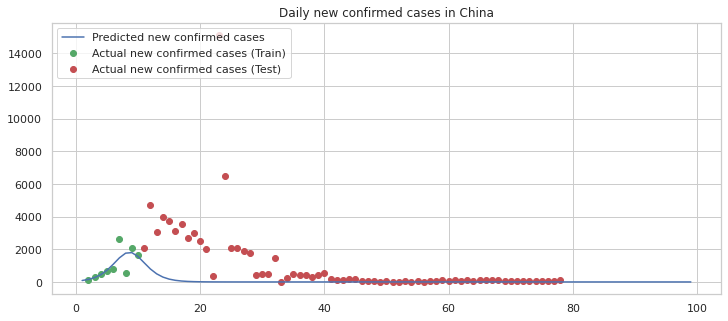

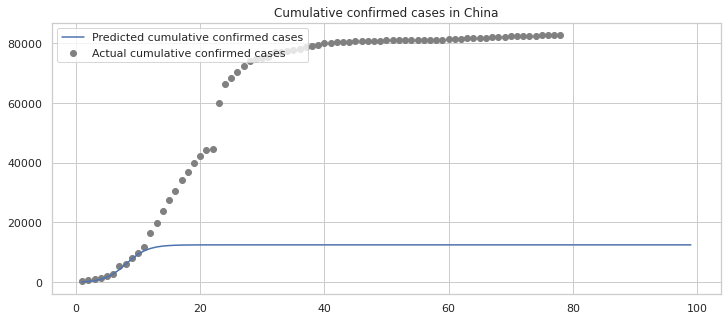

In [213]:
logistic_model_mle_plot_frequency(country='China',n_train=10,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 15377.781792551265
b_pred = -0.32288718775390146
c_pred = 14.510766066818633
MAE (training set) = 466.20714311692694
MAE (test set) = 580.2906800403097


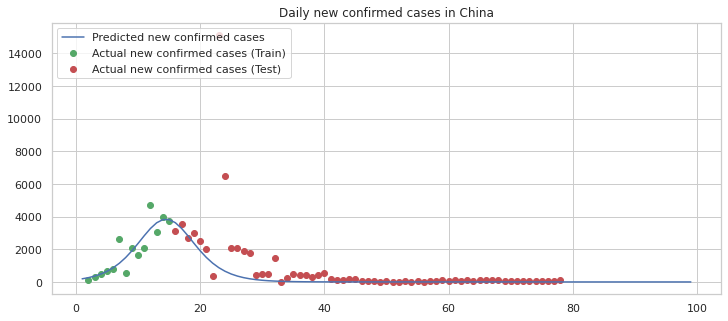

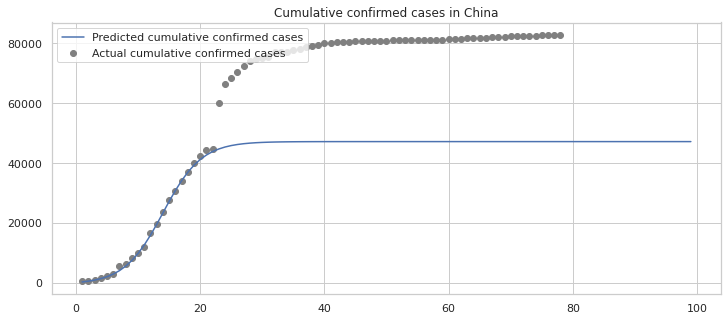

In [214]:
logistic_model_mle_plot_frequency(country='China',n_train=15,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 15277.90539931666
b_pred = -0.301139097418768
c_pred = 14.978750592414233
MAE (training set) = 436.8277700260562
MAE (test set) = 580.3150907522372


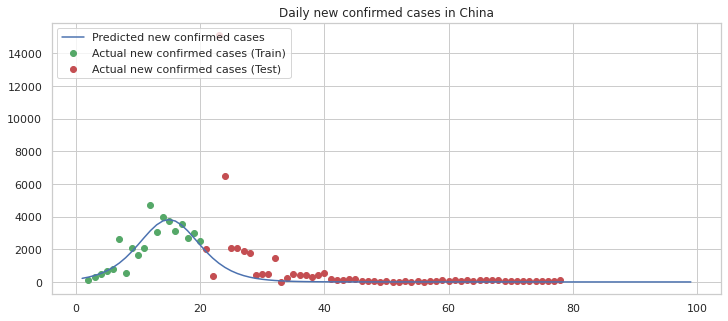

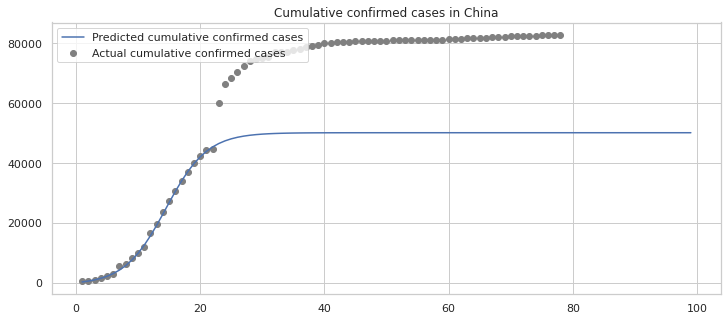

In [215]:
logistic_model_mle_plot_frequency(country='China',n_train=20,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 20054.509177809403
b_pred = -0.15276214755111595
c_pred = 24.270038037214483
MAE (training set) = 1485.0981169569532
MAE (test set) = 980.292569178332


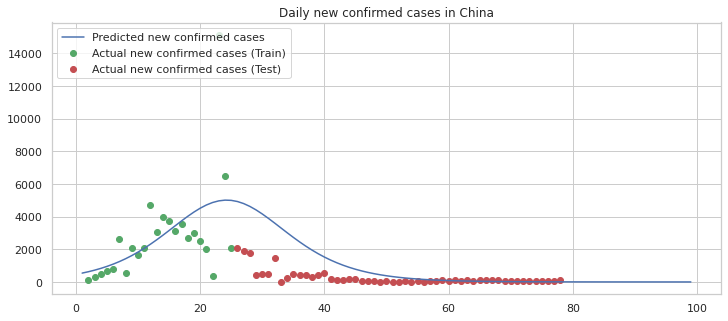

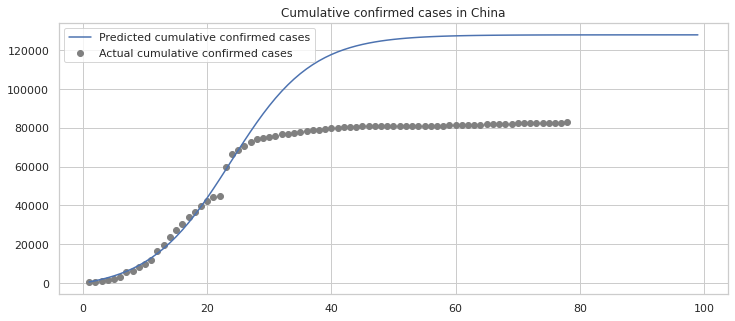

In [216]:
logistic_model_mle_plot_frequency(country='China',n_train=25,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 18027.546624874132
b_pred = 0.218193339234767
c_pred = 19.129591557858376
MAE (training set) = 1403.154316407856
MAE (test set) = 115.17371086422823


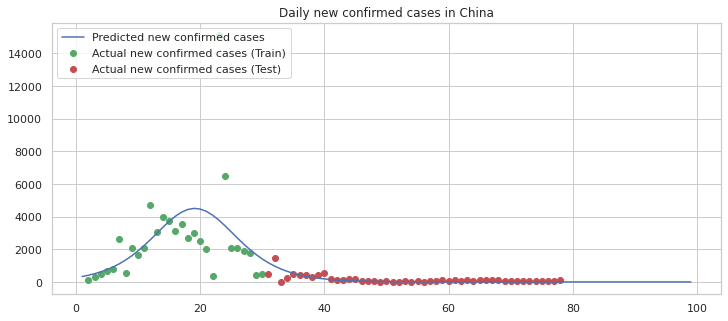

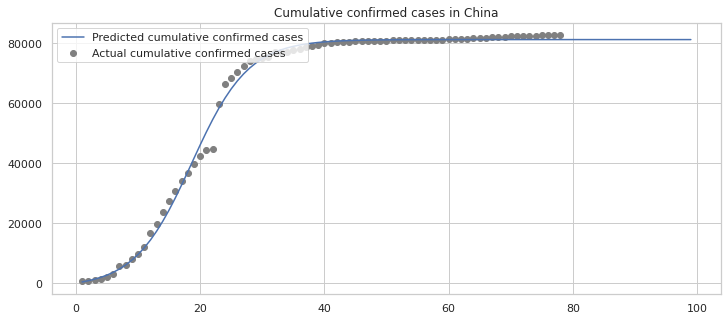

In [217]:
logistic_model_mle_plot_frequency(country='China',n_train=30,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 17887.435161407826
b_pred = -0.2184989181759655
c_pred = 19.018594265612556
MAE (training set) = 1118.275853798251
MAE (test set) = 53.581456086135056


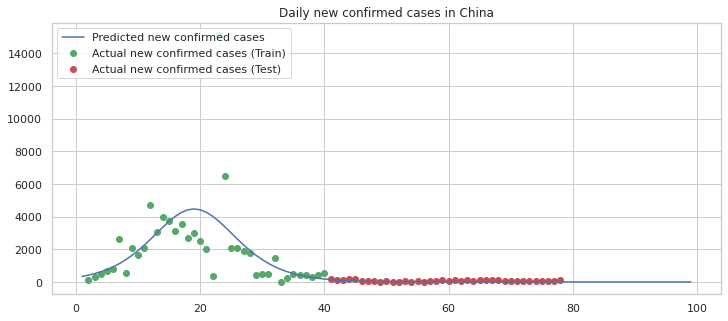

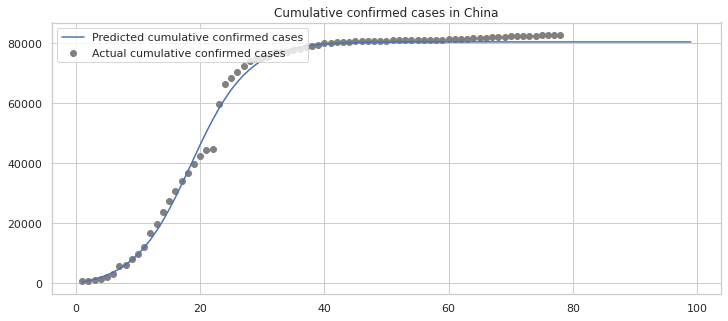

In [218]:
logistic_model_mle_plot_frequency(country='China',n_train=40,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

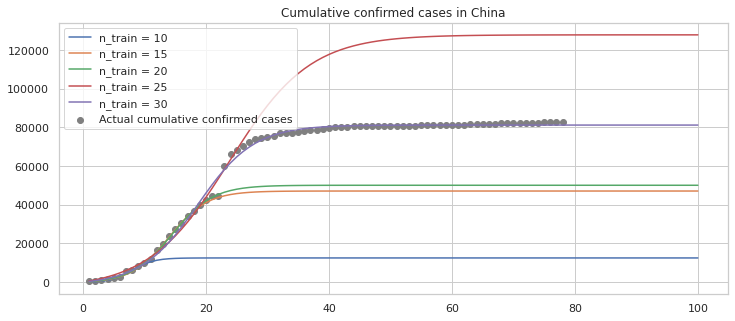

In [220]:
n_train_list = [10,15,20,25,30]
a_list = [7274.028677,15377.78179,15277.9054,20054.50918,18027.54662]
b_list= [-0.576534526,-0.322887188,-0.301139097,-0.152762148,0.218193339]
c_list = [8.610592873,14.51076607,14.97875059,24.27003804,19.12959156]
n_predict= 101
country = 'China'
country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
x= country_cases['day'].to_numpy()
y= country_cases['Confirmed'].to_numpy()
plt.figure(figsize=(12, 5))
plt.scatter(x,y,label="Actual cumulative confirmed cases",color="grey")

for i in range(len(n_train_list)):
  n_train = n_train_list[i]
  a = a_list[i]
  b = b_list[i]
  c = c_list[i]
  x_pred = np.arange(1,n_predict)
  y_pred = logistic_dist_model(x_pred,a=a,b=b,c=c)
  y_pred_accum = np.cumsum(y_pred)
  plt.plot(x_pred, y_pred_accum, label ="n_train = " + str(n_train) )
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
plt.show()

#### Japan

a_pred = 21752.650837198882
b_pred = 0.06161820655727636
c_pred = 154.1826403189143
MAE (training set) = 14.809358312153375
MAE (test set) = 162.55593907960213


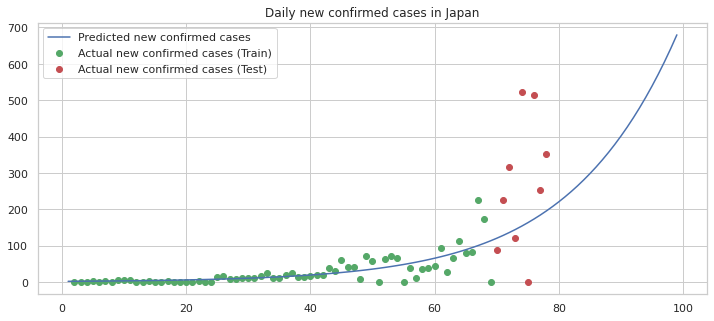

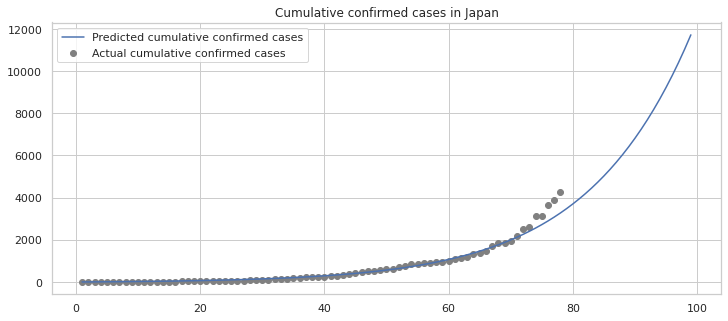

a_pred = 626.7859086994719
b_pred = 0.07390449153937337
c_pred = 86.49411321788102
MAE (training set) = 14.819236094142504
MAE (test set) = 175.23066814112295


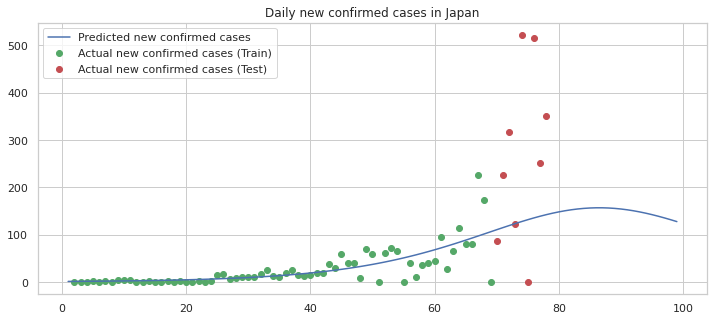

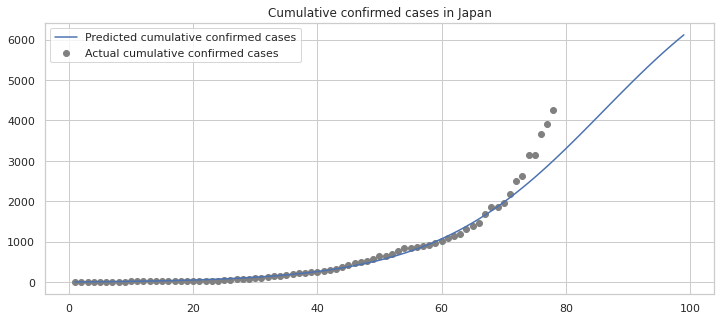

In [201]:
logistic_model_mle_plot_frequency(country='Japan',n_train=69,n_predict = 100,initial_param = [8000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Japan',n_train=69,n_predict = 100,initial_param = [8000, 0.2,100],distribution='poisson')

#### South Korea

a_pred = 2381.636778331458
b_pred = 0.26885041824980827
c_pred = 41.9846315906987
MAE (training set) = 56.83332630650643
MAE (test set) = 85.28164955125084


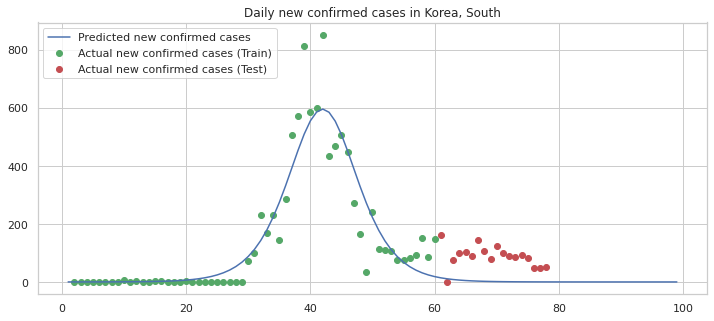

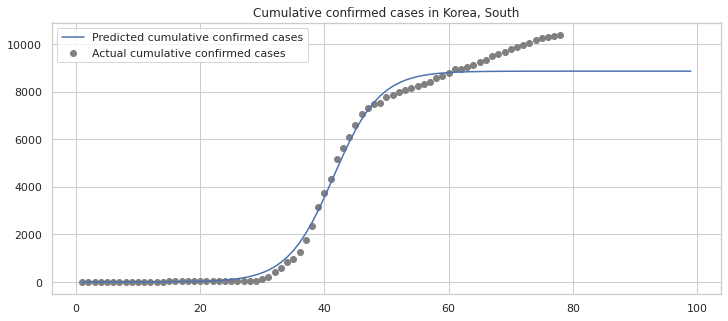

In [203]:
logistic_model_mle_plot_frequency(country='Korea, South',n_train=60,n_predict = 100,initial_param = [8000, 0.2,100],distribution='poisson')

# Compartmental model

## SI model

In [0]:
def SI_model(y,t,beta):
  s = y[0]
  i = y[1]
  ds_dt = -beta * s * i  
  di_dt = beta * s * i
  return ([ds_dt,di_dt])

In [0]:
#initial conditions
s0 = 0.99
i0 = 0.01
beta = 0.1

#Time vector
t= np.arange(0,101)

#Result
solution = scipy.integrate.odeint(SI_model,[s0,i0],t,args=(beta,))
solution = np.array(solution)

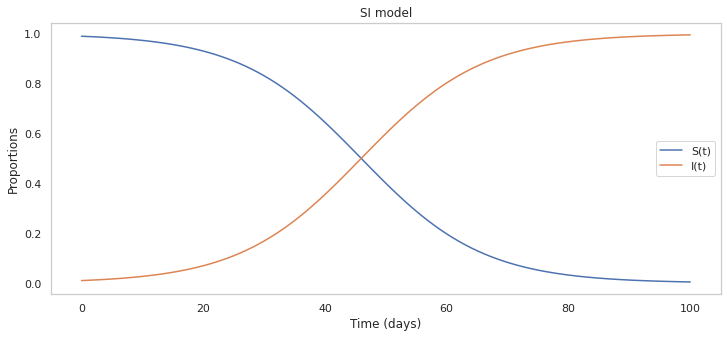

In [80]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="S(t)")
plt.plot(t,solution[:,1],label ="I(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SI model")
plt.show()

## SIS model

In [0]:
def SIS_model(y,t,beta,gamma):
  s = y[0]
  i = y[1]
  ds_dt = -beta * s * i + gamma * i 
  di_dt = beta * s * i - gamma * i
  return ([ds_dt,di_dt])

In [0]:
#initial conditions
s0 = 0.99
i0 = 0.01
beta = 0.25
gamma = 0.1

#Time vector
t= np.arange(0,101)

#Result
solution = scipy.integrate.odeint(SIS_model,[s0,i0],t,args=(beta,gamma))
solution = np.array(solution)

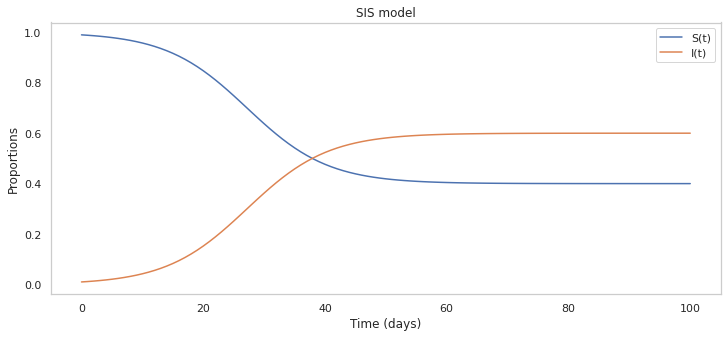

In [83]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="S(t)")
plt.plot(t,solution[:,1],label ="I(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIS model")
plt.show()

## SIR model

In [0]:
def SIR_model(y,t,beta,gamma):
  s = y[0]
  i = y[1]
  r = y[2]
  ds_dt = -beta * s * i  
  di_dt = beta * s * i  - gamma*i
  dr_dt = gamma * i
  return ([ds_dt,di_dt,dr_dt])

In [0]:
#initial conditions
s0 = 1
i0 = 0.000001
r0 = 0.0
beta = 0.25
gamma = 0.1

#Time vector
t= np.arange(0,200)

#Result
solution = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t,args=(beta,gamma))
solution = np.array(solution)

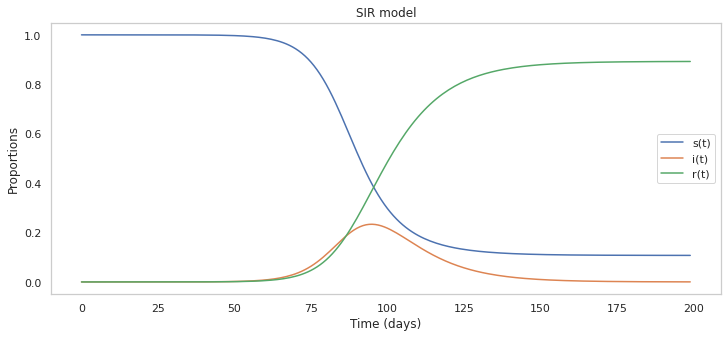

In [86]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="s(t)")
plt.plot(t,solution[:,1],label ="i(t)")
plt.plot(t,solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

#### Different R_0

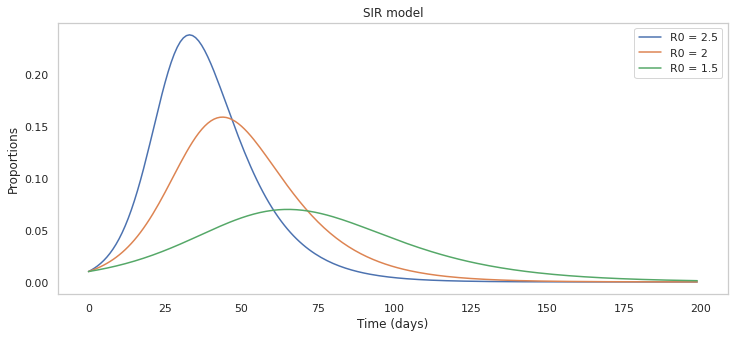

In [87]:
#initial conditions
s0 = 0.99
i0 = 0.01
r0 = 0.0
beta = 0.25
gamma = 0.1

#Time vector
t= np.arange(0,200)

#Result
solution_1 = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t,args=(beta,gamma))
solution_1 = np.array(solution_1)

beta = 0.2
solution_2 = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t,args=(beta,gamma))
solution_2 = np.array(solution_2)


beta = 0.15
solution_3 = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t,args=(beta,gamma))
solution_3 = np.array(solution_3)

#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution_1[:,1],label ="R0 = 2.5")
plt.plot(t,solution_2[:,1],label ="R0 = 2")
plt.plot(t,solution_3[:,1],label ="R0 = 1.5")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

#### Intervention


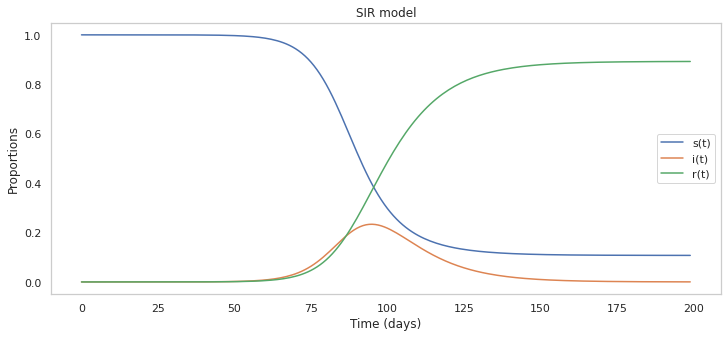

In [88]:
#initial conditions
s0 = 1
i0 = 0.000001
r0 = 0.0
beta = 0.25
gamma = 0.1

#Time vector
t= np.arange(0,200)

#Result
solution = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t,args=(beta,gamma))
solution = np.array(solution)

#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="s(t)")
plt.plot(t,solution[:,1],label ="i(t)")
plt.plot(t,solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

Intervene on day 75

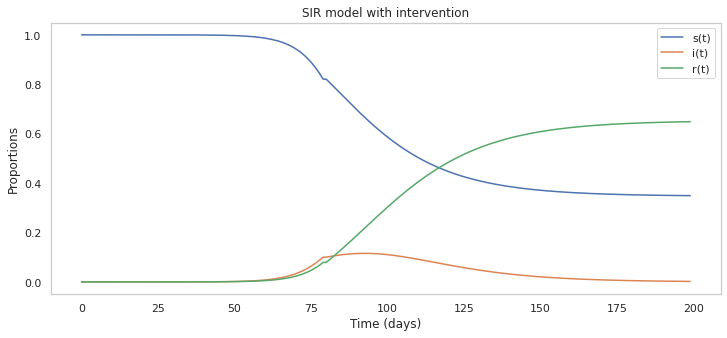

In [89]:
#initial conditions
s0 = 1
i0 = 0.000001
r0 = 0.0
beta = 0.25
gamma = 0.1

#Time vector
t_before= np.arange(0,80)

#Result
solution_before = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t_before,args=(beta,gamma))
solution_before = np.array(solution_before)

s0 = solution_before[-1,0]
i0 = solution_before[-1,1]
r0 = solution_before[-1,2]
beta = 0.15
t_after=np.arange(0,120)
solution_after = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t_after,args=(beta,gamma))
solution_after = np.array(solution_after)

merge_solution = np.concatenate((solution_before,solution_after))
merge_t = np.arange(0,len(t_before)+len(t_after))
#plot
plt.figure(figsize=(12,5))
plt.plot(merge_t,merge_solution[:,0],label ="s(t)")
plt.plot(merge_t,merge_solution[:,1],label ="i(t)")
plt.plot(merge_t,merge_solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model with intervention")
plt.show()

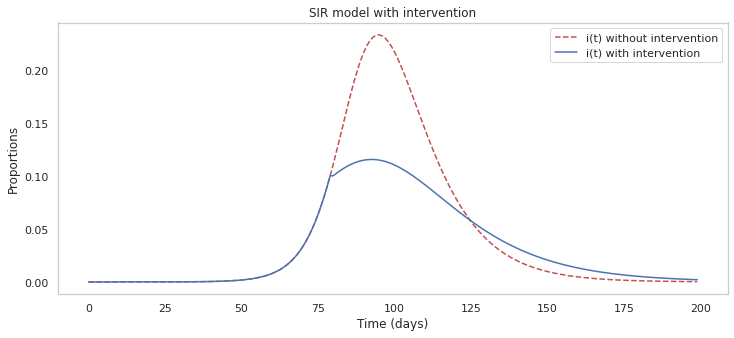

In [90]:
#plot
plt.figure(figsize=(12,5))
plt.plot(merge_t,solution[:,1],'--r',label ="i(t) without intervention")
plt.plot(merge_t,merge_solution[:,1],'b',label ="i(t) with intervention")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model with intervention")
plt.show()

Intervene on day 100

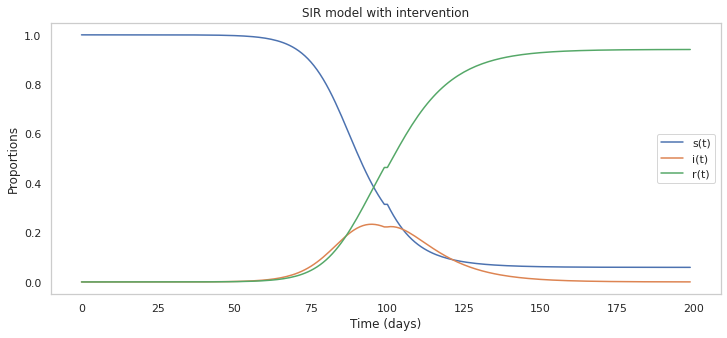

In [91]:
#initial conditions
s0 = 1
i0 = 0.000001
r0 = 0.0
beta = 0.25
gamma = 0.1

#Time vector
t_before= np.arange(0,100)

#Result
solution_before = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t_before,args=(beta,gamma))
solution_before = np.array(solution_before)

s0 = solution_before[-1,0]
i0 = solution_before[-1,1]
r0 = solution_before[-1,2]
beta = 0.35
t_after=np.arange(0,100)
solution_after = scipy.integrate.odeint(SIR_model,[s0,i0,r0],t_after,args=(beta,gamma))
solution_after = np.array(solution_after)

merge_solution = np.concatenate((solution_before,solution_after))
merge_t = np.arange(0,len(t_before)+len(t_after))
#plot
plt.figure(figsize=(12,5))
plt.plot(merge_t,merge_solution[:,0],label ="s(t)")
plt.plot(merge_t,merge_solution[:,1],label ="i(t)")
plt.plot(merge_t,merge_solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model with intervention")
plt.show()

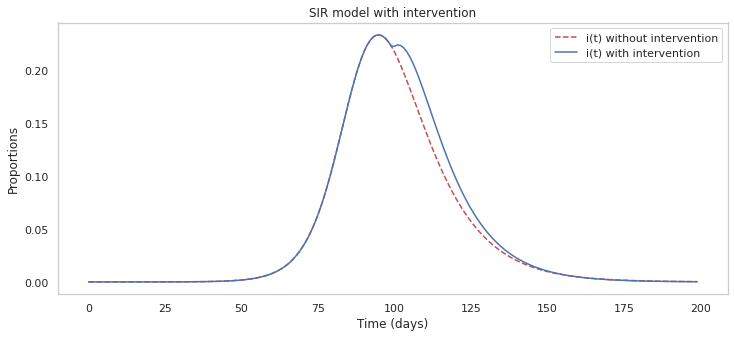

In [92]:
#plot
plt.figure(figsize=(12,5))
plt.plot(merge_t,solution[:,1],'--r',label ="i(t) without intervention")
plt.plot(merge_t,merge_solution[:,1],'b',label ="i(t) with intervention")
plt.grid()
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.title("SIR model with intervention")
plt.show()

## SEIR model


In [0]:
def SEIR_model(y,t,beta,gamma,sigma):
  s = y[0]
  e = y[1]
  i = y[2]
  r = y[3]
  ds_dt = -beta * s * i
  de_dt = beta * s * i  - sigma*e 
  di_dt = sigma*e -gamma*i
  dr_dt = gamma * i
  return ([ds_dt,de_dt,di_dt,dr_dt])

In [0]:
#initial conditions
s0 = 0.999999
e0 = 0.000001
i0 = 0
r0 = 0.0
beta = 0.44
gamma = 0.2
sigma = 0.2
#Time vector
t= np.arange(0,201)

#Result
solution = scipy.integrate.odeint(SEIR_model,[s0,e0,i0,r0],t,args=(beta,gamma,sigma))
solution = np.array(solution)

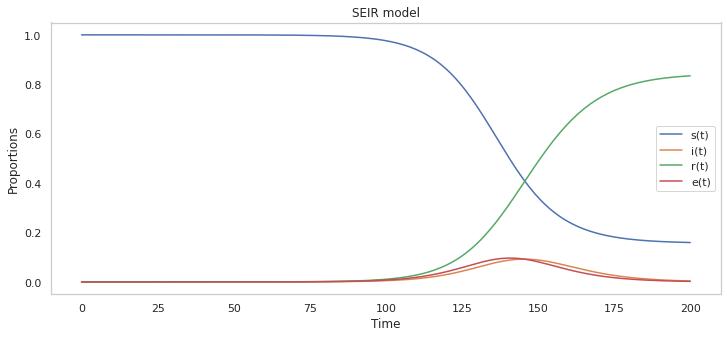

In [95]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="s(t)")

plt.plot(t,solution[:,2],label ="i(t)")
plt.plot(t,solution[:,3],label ="r(t)")
plt.plot(t,solution[:,1],label ="e(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SEIR model")
plt.show()

### SIR model in frequency 

In [0]:
def SIR_model_freq(y,t,beta,gamma):
  S = y[0]
  I = y[1]
  R = y[2]
  N = S + I + R
  dS_dt = -beta *S * I / (N)  
  dI_dt = beta * S * I / (N)  - gamma*I
  dR_dt = gamma * I
  return ([dS_dt,dI_dt,dR_dt])

In [0]:
#initial conditions (in frequency)
S0 = 5000
I0 = 2
R0 = 0.0
beta = 0.35
gamma = 0.1

#Time vector
t= numpy.linspace(0,100,10000)

#Result
solution = scipy.integrate.odeint(SIR_model_freq,[S0,I0,R0],t,args=(beta,gamma))
solution = numpy.array(solution)

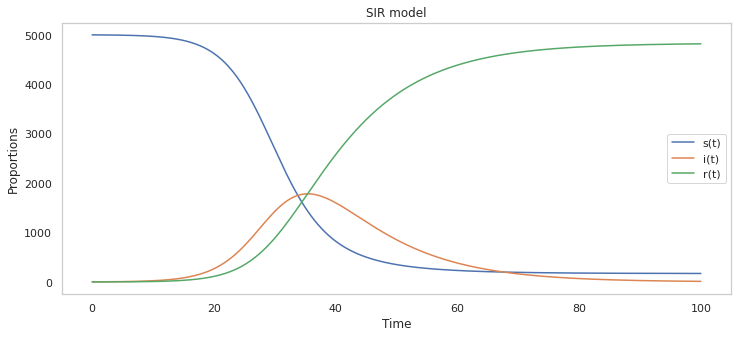

In [98]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="s(t)")
plt.plot(t,solution[:,1],label ="i(t)")
plt.plot(t,solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

In [0]:
# sol = solve_ivp(SIR_model,[0,14],[762,1,0],t_eval=np.arange(0,14.2,0.2))

# fig = plt.figure(figsize=(12,4))
# plt.plot(sol.t,sol.y[0])
# plt.plot(sol.t,sol.y[1])
# plt.plot(sol.t,sol.y[2])
# plt.plot(np.arange(0,15),data,"k*:")
# plt.grid("True")
# plt.legend(["Susceptible","Infected","Removed","Original Data"])

[ 7.91301665e-05 -8.32369133e-02]


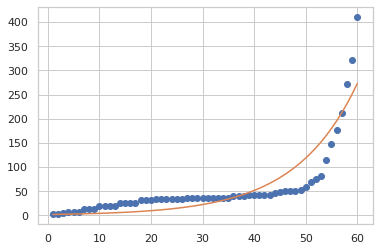

In [100]:
#TEST
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

n = 60
country= 'Thailand'
thailand_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']==country)]
x_train = thailand_cases['day'].to_numpy()
y_train = thailand_cases['Confirmed'].to_numpy()


def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model_freq, (S0, I0, R0), x, args=(beta, gamma))[:,1]


S0 = 5000
I0 = 2
R0 = 0.0
N = S0 + I0 + R0
beta = 0.35
gamma = 0.1

popt, pcov = optimize.curve_fit(fit_odeint, x_train, y_train)
print(popt)
fitted = fit_odeint(x_train, popt[0],popt[1])

plt.plot(x_train, y_train, 'o')
plt.plot(x_train, fitted)
plt.show()

In [0]:
S0 = 5000
I0 = 2
R0 = 0.0
N = S0 + I0 + R0
beta = 0.000079
gamma = -0.0832

In [0]:
#Time vector
t= numpy.linspace(0,100,10000)

#Result
solution = scipy.integrate.odeint(SIR_model_freq,[S0,I0,R0],t,args=(beta,gamma))
solution = numpy.array(solution)

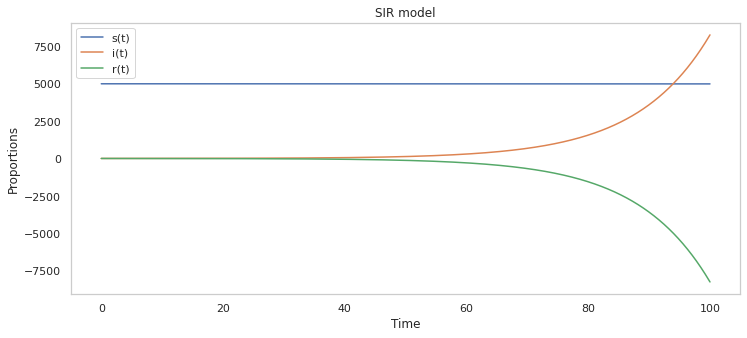

In [103]:
#plot
plt.figure(figsize=(12,5))
plt.plot(t,solution[:,0],label ="s(t)")
plt.plot(t,solution[:,1],label ="i(t)")
plt.plot(t,solution[:,2],label ="r(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

In [0]:
#Test 2

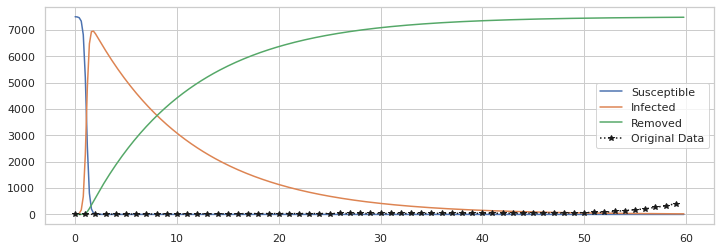

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

n = 60
country= 'Thailand'
thailand_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']==country)]
x_train = thailand_cases['day'].to_numpy()
y_train = thailand_cases['Confirmed'].to_numpy()
data = y_train
size = len(data)
# size = 120
# data =  np.concatenate((y_train, [None] * (size - len(data))))

beta,gamma = [0.001,0.1]

def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    N= (S+I+R)
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

sol = solve_ivp(SIR,[0,size],[7500,2,0],t_eval=np.arange(0,size,0.2))

fig = plt.figure(figsize=(12,4))
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.plot(sol.t,sol.y[2])
plt.plot(np.arange(0,size),data,"k*:")
plt.grid("True")
plt.legend(["Susceptible","Infected","Removed","Original Data"])

In [0]:
def sumsq(p):
    beta, gamma = p
    def SIR(t,y):
      S = y[0]
      I = y[1]
      R = y[2]
      return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
    sol = solve_ivp(SIR,[0,size],[15000,2,0],t_eval=np.arange(0,size,0.2))
    return(sum((sol.y[1][::5]-data)**2))

In [107]:
from scipy.optimize import minimize

# msol = minimize(sumsq,[0.001,1],method='Nelder-Mead')
msol =  minimize(
            sumsq,
            [0.001,  1],
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
msol.x

array([0.4, 0.4])

In [0]:
beta,gamma = msol.x
def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
sol = solve_ivp(SIR,[0,size],[762,1,0],t_eval=np.arange(0,size+0.2,0.2))

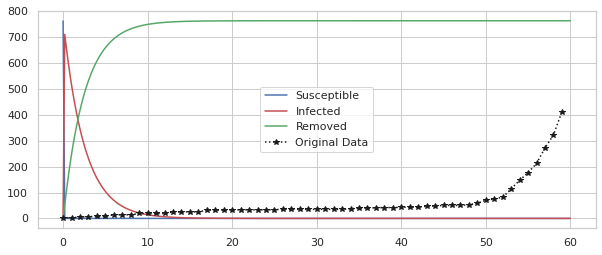

In [109]:
fig = plt.figure(figsize=(10,4))
plt.plot(sol.t,sol.y[0],"b-")
plt.plot(sol.t,sol.y[1],"r-")
plt.plot(sol.t,sol.y[2],"g-")
plt.plot(np.arange(0,size),data,"k*:")
plt.legend(["Susceptible","Infected","Removed","Original Data"])

from [number and shape](https://numbersandshapes.net/post/fitting_sir_to_data_in_python/)

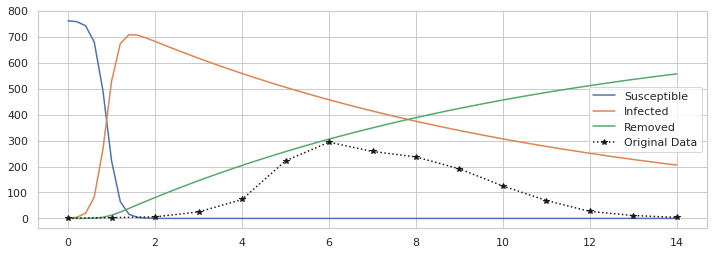

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

data = [1, 3, 6, 25, 73, 222, 294, 258, 237, 191, 125, 69, 27, 11, 4]
beta,gamma = [0.01,0.1]

def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

sol = solve_ivp(SIR,[0,14],[762,1,0],t_eval=np.arange(0,14.2,0.2))

fig = plt.figure(figsize=(12,4))
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.plot(sol.t,sol.y[2])
plt.plot(np.arange(0,15),data,"k*:")
plt.grid("True")
plt.legend(["Susceptible","Infected","Removed","Original Data"])

In [0]:
def sumsq(p):
    beta, gamma = p
    def SIR(t,y):
      S = y[0]
      I = y[1]
      R = y[2]
      return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
    sol = solve_ivp(SIR,[0,14],[762,1,0],t_eval=np.arange(0,14.2,0.2))
    return(sum((sol.y[1][::5]-data)**2))

In [112]:
from scipy.optimize import minimize

msol = minimize(sumsq,[0.001,1],method='Nelder-Mead')
msol.x

array([0.00218035, 0.44553886])

In [0]:
beta,gamma = msol.x
def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
sol = solve_ivp(SIR,[0,14],[762,1,0],t_eval=np.arange(0,14.2,0.2))

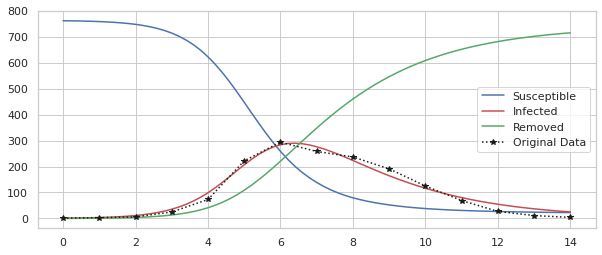

In [114]:
fig = plt.figure(figsize=(10,4))
plt.plot(sol.t,sol.y[0],"b-")
plt.plot(sol.t,sol.y[1],"r-")
plt.plot(sol.t,sol.y[2],"g-")
plt.plot(np.arange(0,15),data,"k*:")
plt.legend(["Susceptible","Infected","Removed","Original Data"])

from [stack overflow](https://stackoverflow.com/questions/34422410/fitting-sir-model-based-on-least-squares)

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


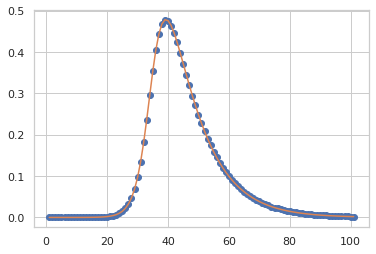

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

ydata = ['1e-06', '1.49920166169172e-06', '2.24595472686361e-06', '3.36377954575331e-06', '5.03793663882291e-06', '7.54533628058909e-06', '1.13006564683911e-05', '1.69249500601052e-05', '2.53483161761933e-05', '3.79636391699325e-05', '5.68567547875179e-05', '8.51509649182741e-05', '0.000127522555808945', '0.000189928392105942', '0.000283447055673738', '0.000423064043409294', '0.000631295993246634', '0.000941024110897193', '0.00140281896645859', '0.00209085569326554', '0.00311449589149717', '0.00463557784224762', '0.00689146863803467', '0.010227347567051', '0.0151380084180746', '0.0223233100045688', '0.0327384810150231', '0.0476330618585758', '0.0685260046667727', '0.0970432959143974', '0.134525888779423', '0.181363340075877', '0.236189247803334', '0.295374180276257', '0.353377036130714', '0.404138746080267', '0.442876028839178', '0.467273954573897', '0.477529937494976', '0.475582401936257', '0.464137179474659', '0.445930281787152', '0.423331710456602', '0.39821360956389', '0.371967226561944', '0.345577884704341', '0.319716449520481', '0.294819942458255', '0.271156813453547', '0.24887641905719', '0.228045466022105', '0.208674420183194', '0.190736203926912', '0.174179448652951', '0.158937806544529', '0.144936441326754', '0.132096533873646', '0.120338367115739', '0.10958340819268', '0.099755679236243', '0.0907826241267504', '0.0825956203546979', '0.0751302384111894', '0.0683263295744258', '0.0621279977639921', '0.0564834809370572', '0.0513449852139111', '0.0466684871328814', '0.042413516167789', '0.0385429293775096', '0.035022685071934', '0.0318216204865132', '0.0289112368382048', '0.0262654939162707', '0.0238606155312519', '0.021674906523588', '0.0196885815912485', '0.0178836058829335', '0.0162435470852779', '0.0147534385851646', '0.0133996531928511', '0.0121697868544064', '0.0110525517526551', '0.0100376781867076', '0.00911582462544914', '0.00827849534575178', '0.00751796508841916', '0.00682721019158058', '0.00619984569061827', '0.00563006790443123', '0.00511260205894446', '0.00464265452957236', '0.00421586931435123', '0.00382828837833139', '0.00347631553734708', '0.00315668357532714', '0.00286642431380459', '0.00260284137520731', '0.00236348540287827', '0.00214613152062159', '0.00194875883295343']
xdata = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101']

ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

def sir_model(y, x, beta, gamma):
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

N = 1.0
I0 = ydata[0]
S0 = N - I0
R0 = 0.0

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.show()

In [0]:
#TEST2

from [here](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

In [0]:
### make it works

In [0]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    S_0 = 60000000
    I_0 = 2
    R_0 = 0
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        N = S + I +R
        return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
def train():
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        # data = [1, 3, 6, 25, 73, 222, 294, 258, 237, 191, 125, 69, 27, 11, 4]
        country= 'Thailand'
        thailand_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']==country)]
        x_train = thailand_cases['day'].to_numpy()
        y_train = thailand_cases['Confirmed'].to_numpy()
        data = y_train
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.1, 0.4), (0.05, 0.4)]
        )
        beta, gamma = optimal.x
        print('beta = '+str(beta)+ 'gamma = '+str(gamma))
        extended_actual, prediction = predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        })
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title('Thailand')
        df.plot(ax=ax)
def predict(beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 200
        size = predict_range
        S_0 = 10000
        I_0 = 2
        R_0 = 0
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            N = S + I +R
            return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
        extended_actual = np.concatenate((data, [None] * (size - len(data))))
        return extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

beta = 0.13332262664903263gamma = 0.05


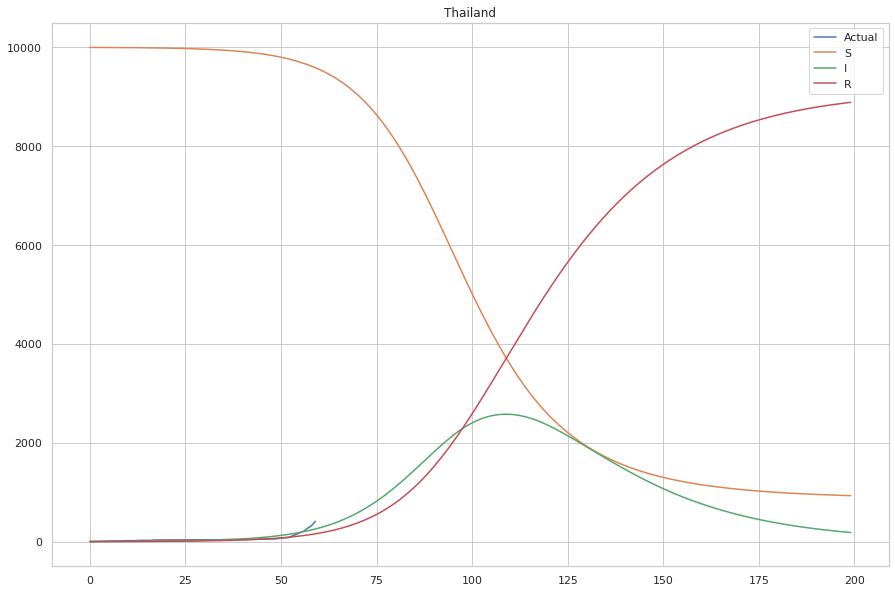

In [119]:
train()


beta = 0.13332262664903263gamma = 0.05


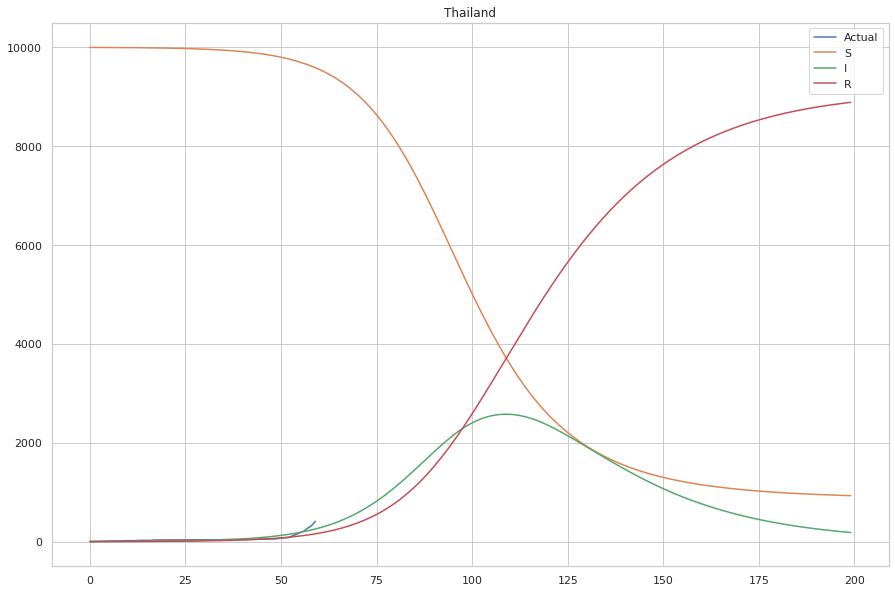

In [120]:
train()
